# Setup

In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

In [76]:
report_output_root_dir = Path('../output/txt')

report_output_dirs = {'gtzan_multi': report_output_root_dir / 'gtzan_multi',
                      'fma_small_multi': report_output_root_dir / 'fma_small_multi',
                      'fma_medium_multi': report_output_root_dir / 'fma_medium_multi',
                      
                      'gtzan_binary': report_output_root_dir / 'gtzan_binary',
                      'fma_small_binary': report_output_root_dir / 'fma_small_binary',
                      'fma_medium_binary': report_output_root_dir / 'fma_medium_binary'}

In [77]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10

fma_small_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

fma_medium_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock',
                          'Easy Listening', 'Blues', 'Soul-RnB', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Classical'] #16

## Colors

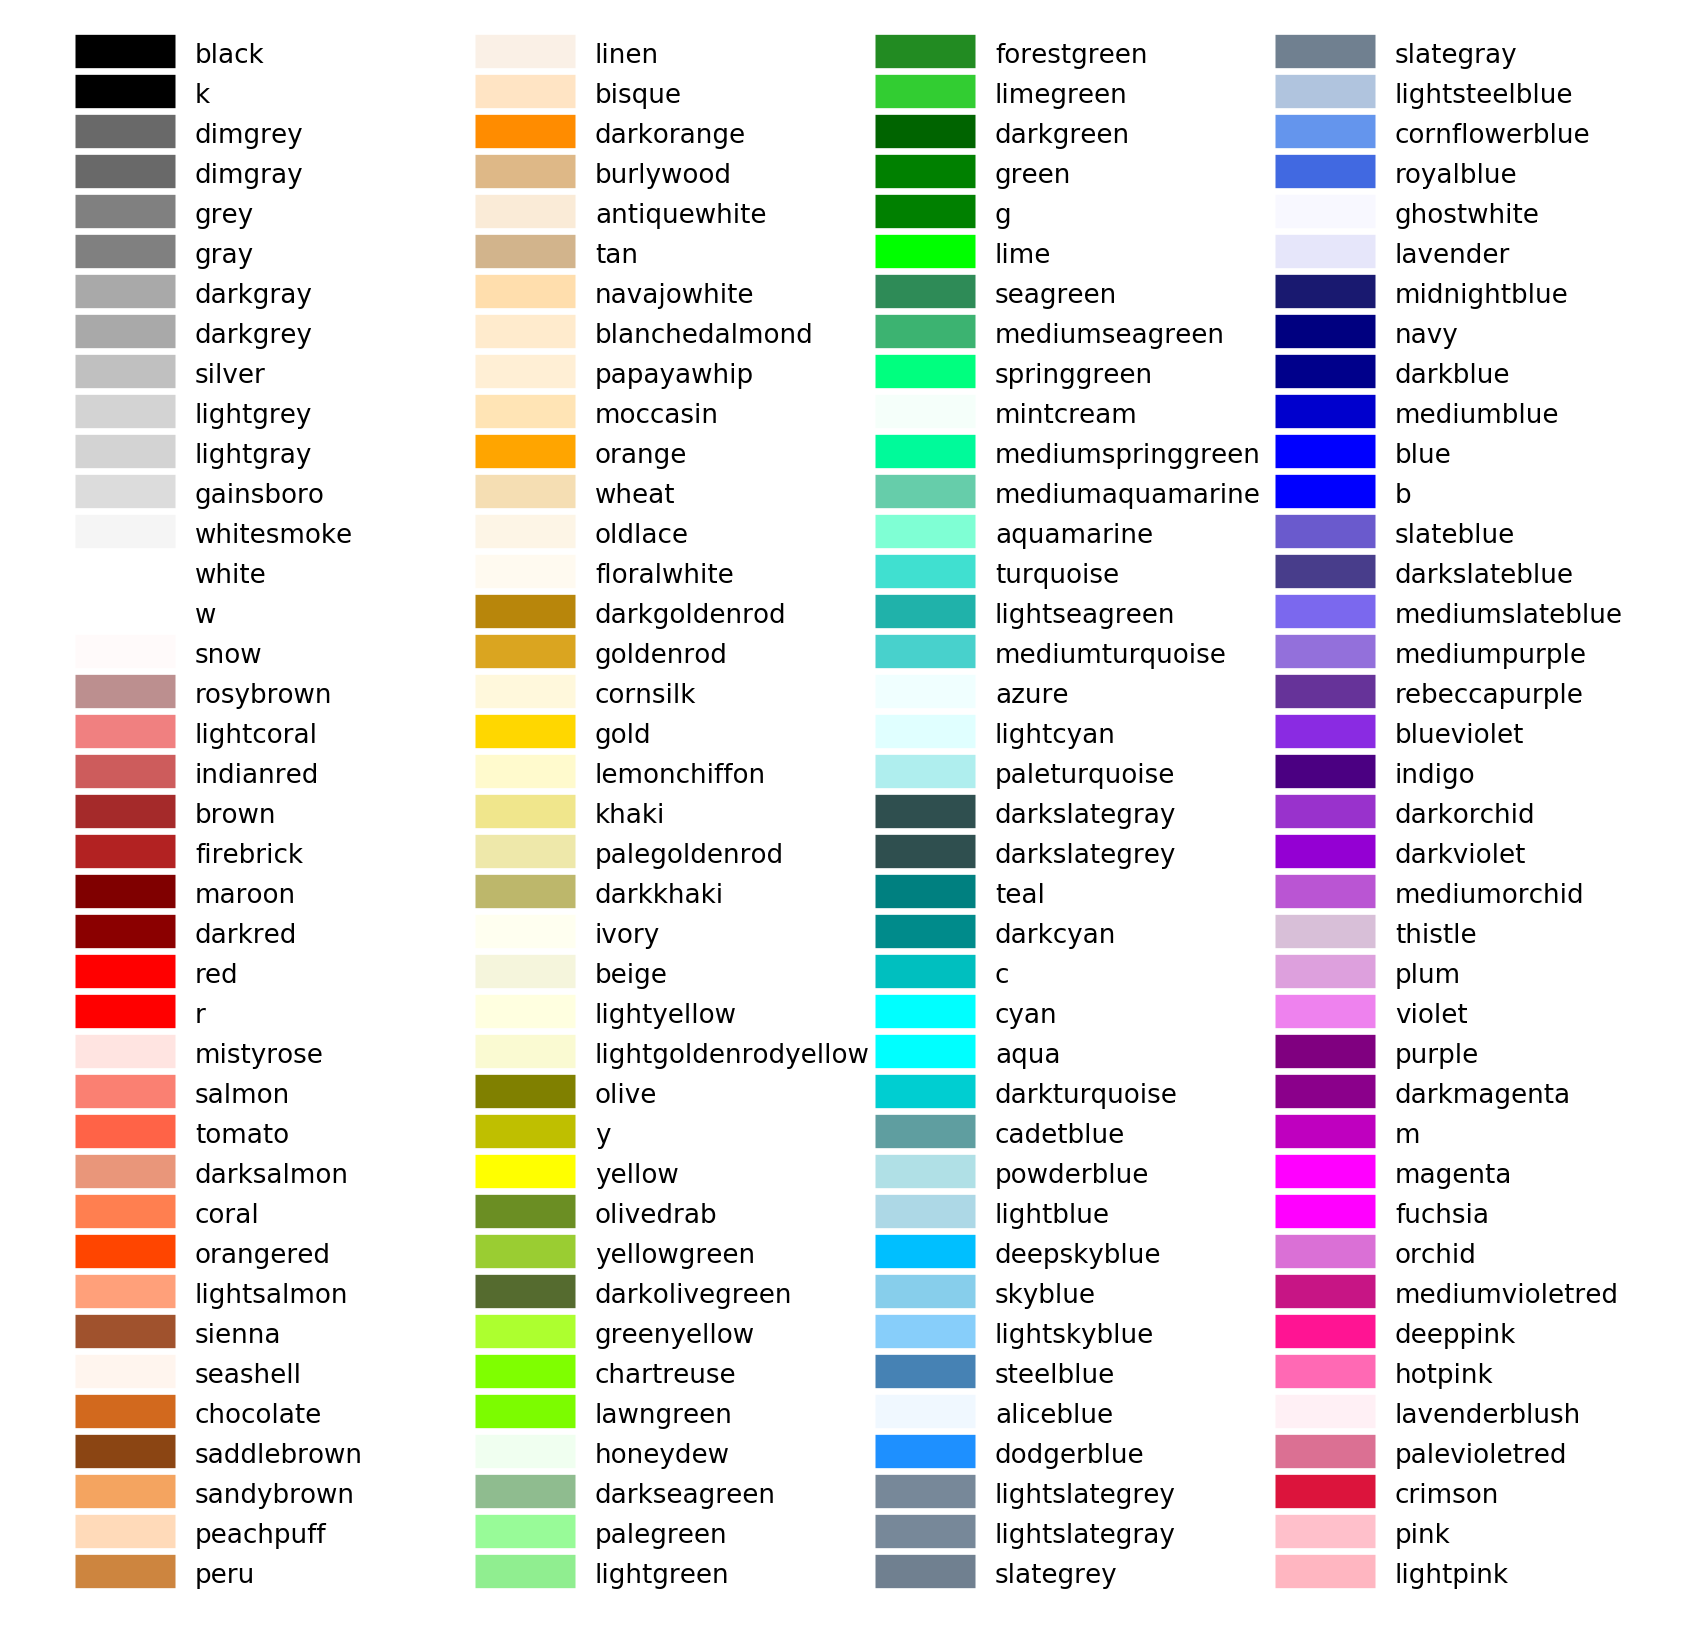

In [110]:
single_multi_metrics = {'macro_accuracy': 'darkred', 'micro_accuracy': 'red',
                        'macro_f1': 'orangered', 'micro_f1': 'lightsalmon',
                        'macro_precision': 'olive', 'micro_precision': 'y',
                        'macro_recall': 'darkgreen', 'micro_recall': 'limegreen',
                        "Cohen's Kappa": 'mediumblue', 'MCC': 'cornflowerblue',
                        'MSE': 'darkslateblue', 'LogLoss': 'black',
                        'AUNu': 'indigo', 'AUNp': 'darkviolet', 'AU1u': 'mediumvioletred', 'AU1p': 'hotpink'}

In [79]:
# single_multi_metrics = ['macro_accuracy', 'micro_accuracy',
#                         'macro_f1', 'micro_f1',
#                         'macro_precision', 'micro_precision',
#                         'macro_recall', 'micro_recall',
#                         "Cohen's Kappa", 'MCC',
#                         'MSE', 'LogLoss',
#                         'AUNu', 'AUNp', 'AU1u', 'AU1p']

In [80]:
single_binary_metrics = ['accuracy', 'f1',
                         'precision', 'recall',
                         "cohen's kappa", 'MCC',
                         'MSE', 'LogLoss',
                         'binary_ROC-AUC']

# Helpers

In [91]:
def remove_keys(dict, keys_to_be_removed):
    for key in keys_to_be_removed:
        dict.pop(key, None)
    return dict

In [109]:
def get_keys_and_value_pairs(dict, keys):
    return {k: v for k, v in dict.items() if k in keys}

## Data

In [9]:
def get_sorted_report_dicts_for_model(base_dir, model_name):
    model_dir = base_dir / model_name
    model_subdirs = [x for x in model_dir.iterdir() if x.is_dir()]
    model_reports = [x / '1.json' for x in model_subdirs]
    model_report_dicts = [json.load(open(x)) for x in model_reports]
    model_report_dicts.sort(key=lambda x: x['epochs'])
    return model_report_dicts

In [10]:
def get_min_max_epochs(model_reports):
    min_epochs = model_reports[0]['epochs']
    max_epochs = model_reports[-1]['epochs']
    return min_epochs, max_epochs

In [11]:
class experiment_info:
    def __init__(self, model_name, dataset_name, classification_type, test_set, class_names):
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.classification_type = classification_type
        self.test_set = test_set
        self.class_names = class_names

In [12]:
def get_experiment_info(model_reports, class_names):
    model_name = model_reports['model name']
    dataset_name = model_reports['dataset name']
    classification_type = model_reports['classification type']
    test_set = model_reports['test set']
    class_names = class_names
    return experiment_info(model_name, dataset_name, classification_type, test_set, class_names)

In [13]:
def check_if_same_in_every_epoch(model_reports, metric_name1, metric_name2):
    metric1_values = [x['metrics'][metric_name1] for x in model_reports]
    metric2_values = [x['metrics'][metric_name2] for x in model_reports]
    return all(metric1_values[i] == metric2_values[i] for i in range(len(metric1_values)))

In [38]:
def find_biggest_difference(model_reports, metric_name1, metric_name2):
    metric1_values = [x['metrics'][metric_name1] for x in model_reports]
    metric2_values = [x['metrics'][metric_name2] for x in model_reports]
    differences = [abs(metric1_values[i] - metric2_values[i]) for i in range(len(metric1_values))]
    max_difference = max(differences)
    max_index = differences.index(max_difference)
    return max_difference, model_reports[max_index]['epochs']

## Drawing

In [93]:
def draw_plots_for_model(ax, metrics_with_colors, model_reports):
    epochs = [x['epochs'] for x in model_reports]
    
    for metric, color in metrics_with_colors.items():
        metric_values = [x['metrics'][metric] for x in model_reports]
        sns.lineplot(x=epochs, y=metric_values, marker='o', label=metric, ax=ax, color=color)

In [94]:
def draw_figure_for_model(experiment_info, metrics_with_colors, reports):
    dataset_description = f"{experiment_info.dataset_name} {experiment_info.classification_type}"
    model_description = f"{experiment_info.model_name}, {dataset_description}, {experiment_info.test_set}"
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    
    draw_plots_for_model(ax, metrics_with_colors, reports)
    
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('metric value')
    ax.set_title(model_description)
    
    plt.show()

## Combined

In [111]:
def draw_figures_for_multi_model(base_dir, model_name, classes, metrics_with_colors, same_class_counts=True):
    model_reports = get_sorted_report_dicts_for_model(base_dir, model_name)
    model_exp_info = get_experiment_info(model_reports[0], classes)
    
    # first figure (most metrics)
    metrics_fig1 = metrics_with_colors.copy()
    remove_keys(metrics_fig1, ['MSE', 'LogLoss']) 
    if same_class_counts:
        remove_keys(metrics_fig1, ['AUNp', 'AU1u', 'AU1p'])
    draw_figure_for_model(model_exp_info, metrics_fig1, model_reports)
    
    # second figure (LogLoss)
    logloss_with_color = get_keys_and_value_pairs(metrics_with_colors, ['LogLoss'])
    draw_figure_for_model(model_exp_info, logloss_with_color, model_reports)
    
    # third figure (MSE)
    mse_with_colors = get_keys_and_value_pairs(metrics_with_colors, ['MSE'])
    draw_figure_for_model(model_exp_info, mse_with_colors, model_reports)
    
    # fourth figure (AUNu, AUNp, AU1u, AU1p)
    metrics_fig4_with_colors = {k: v for k, v in metrics_with_colors.items() if k in ['AUNu', 'AUNp', 'AU1u', 'AU1p']}
    draw_figure_for_model(model_exp_info, metrics_fig4_with_colors, model_reports)
    
    # macro vs micro
    macro_micro_metrics = { 'accuracy': {'macro_accuracy', 'micro_accuracy'},
                             'f1': {'macro_f1', 'micro_f1'},
                             'precision': {'macro_precision', 'micro_precision'},
                             'recall': {'macro_recall', 'micro_recall'}}
    
    for metric, macro_micro in macro_micro_metrics.items():
        (macro, micro) = macro_micro
        is_same = check_if_same_in_every_epoch(model_reports, *macro_micro)
        print(f"{macro} is same as {micro} in every epoch: {is_same}")
        
        if not is_same:
            max_dif, epoch_max_dif = find_biggest_difference(model_reports, *macro_micro)
            print(f'Biggest difference: {max_dif} in epoch {epoch_max_dif}')
             
        macro_micro_with_colors = get_keys_and_value_pairs(metrics_with_colors, [*macro_micro])       
        draw_figure_for_model(model_exp_info, macro_micro_with_colors, model_reports)

# GTZAN multi

In [89]:
gtzan_multi_output_dir = report_output_dirs['gtzan_multi']

## Model4_5_spacing

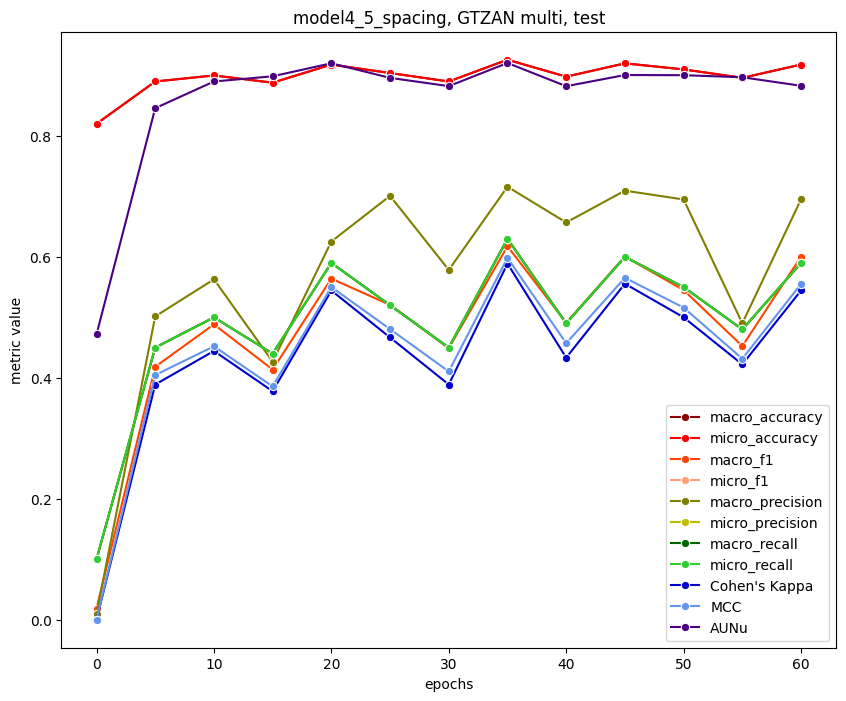

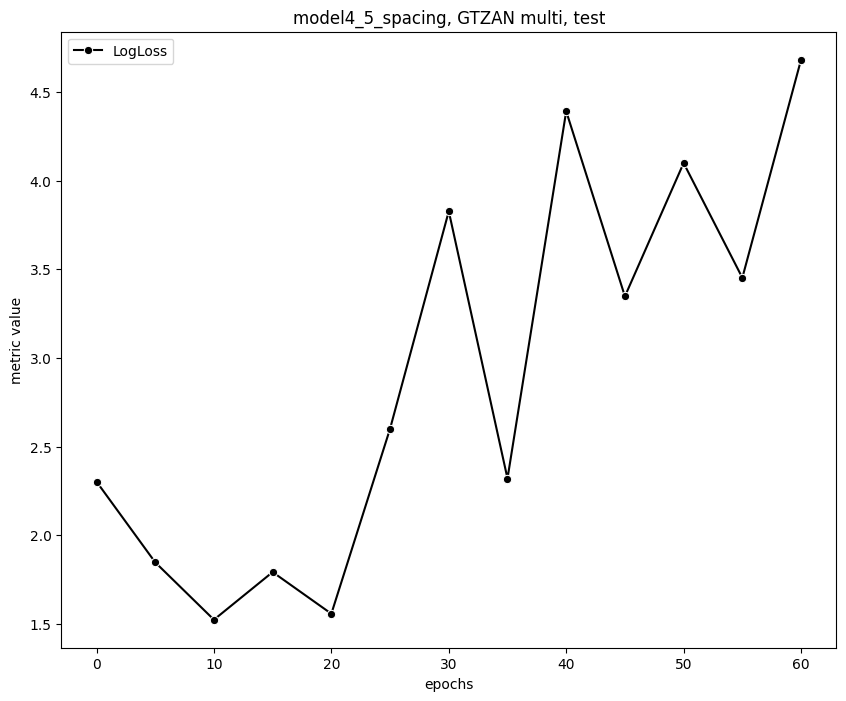

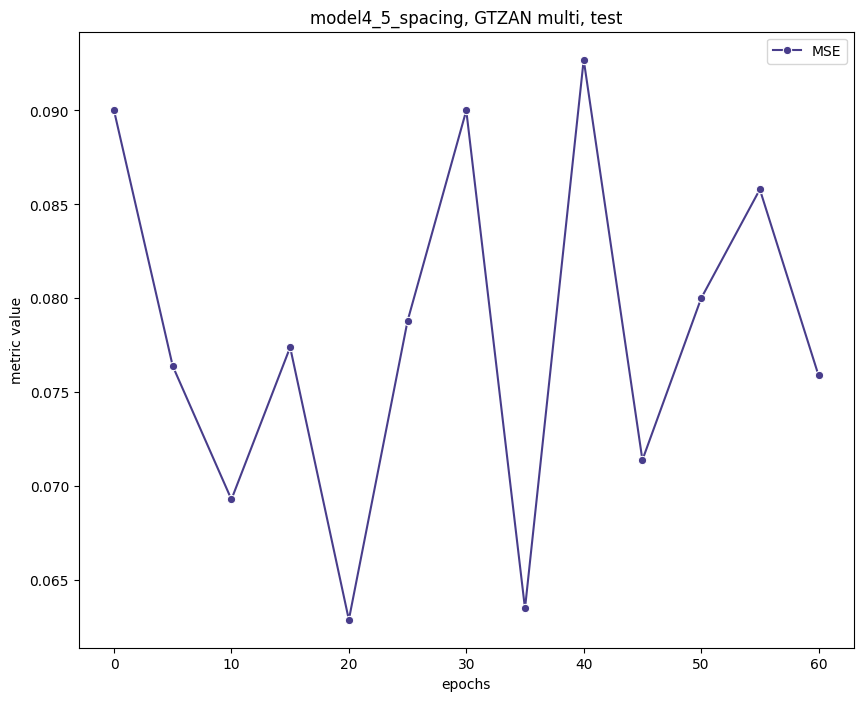

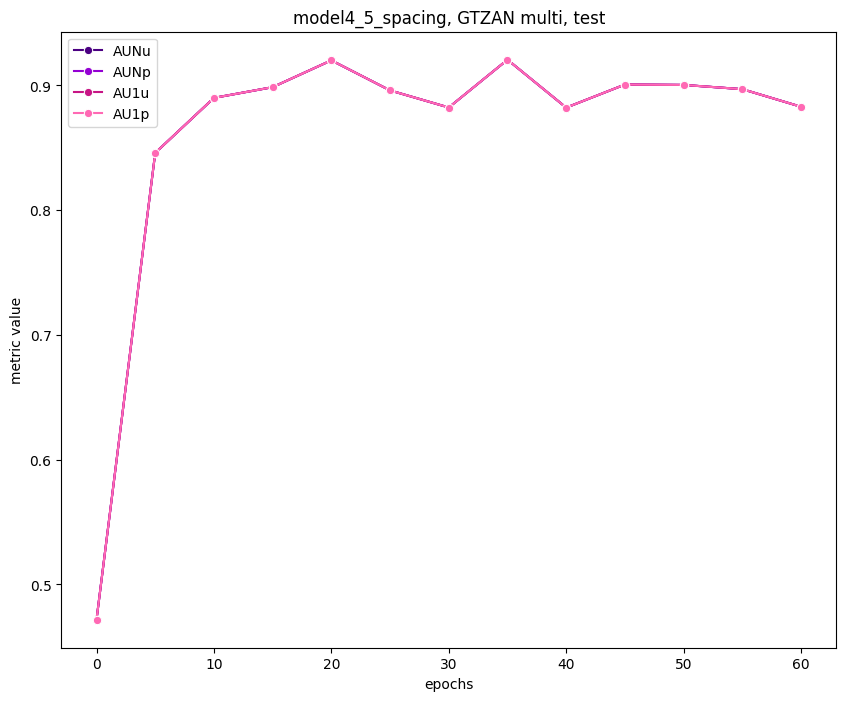

macro_accuracy is same as micro_accuracy in every epoch: True


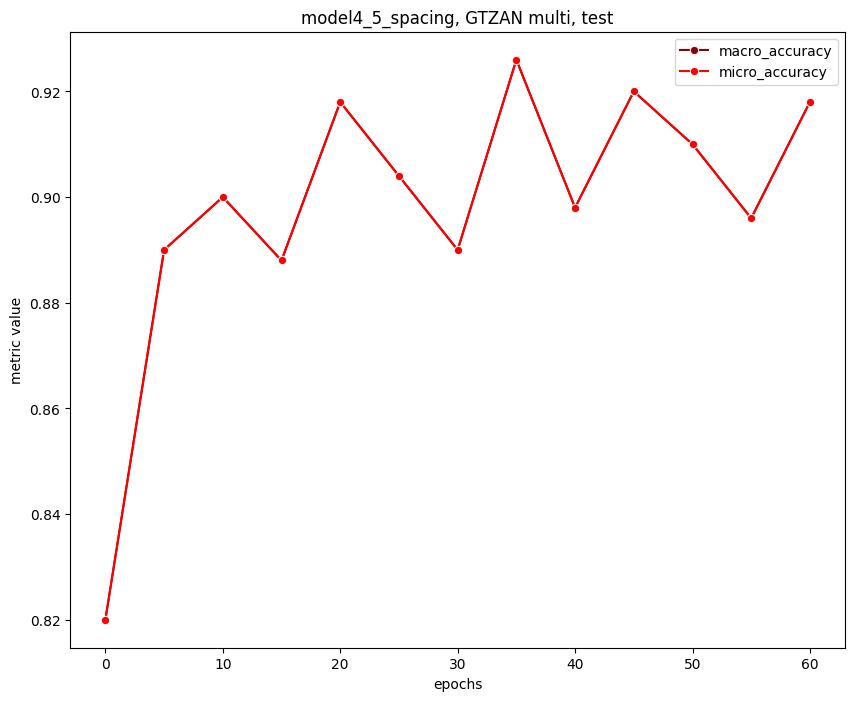

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.08180000000000001 in epoch 0


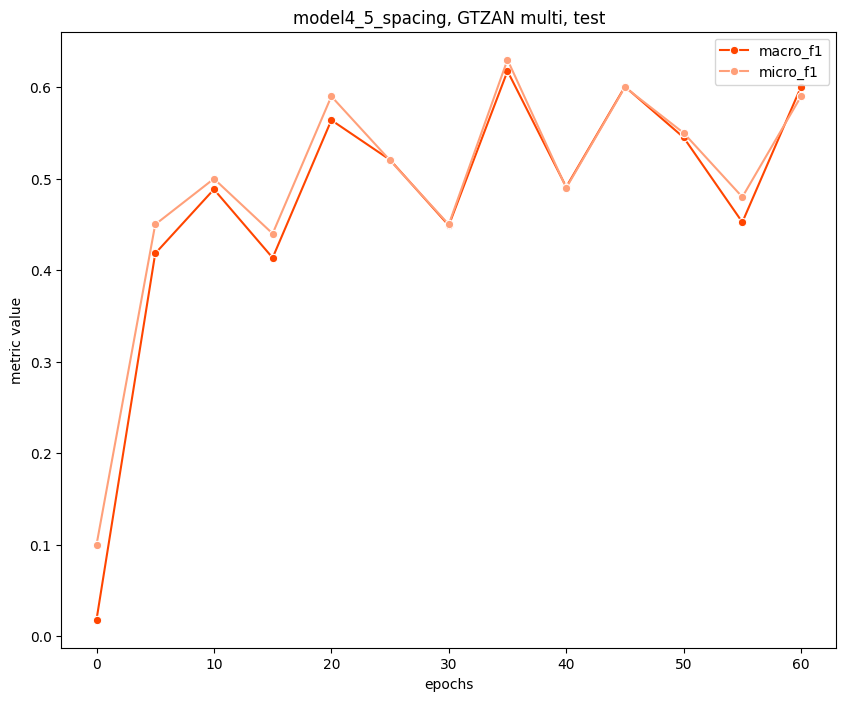

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.18089999999999995 in epoch 25


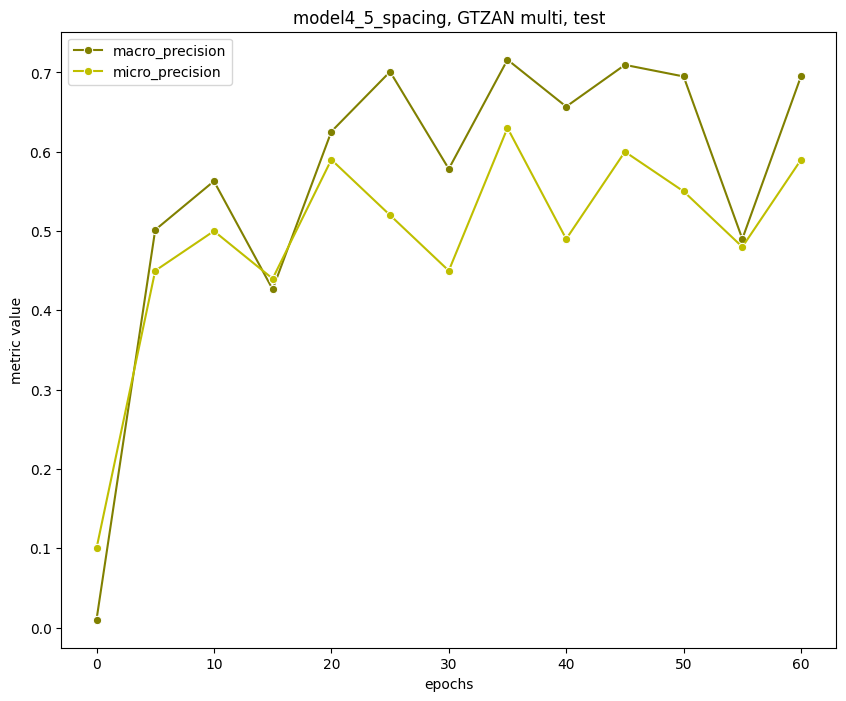

macro_recall is same as micro_recall in every epoch: True


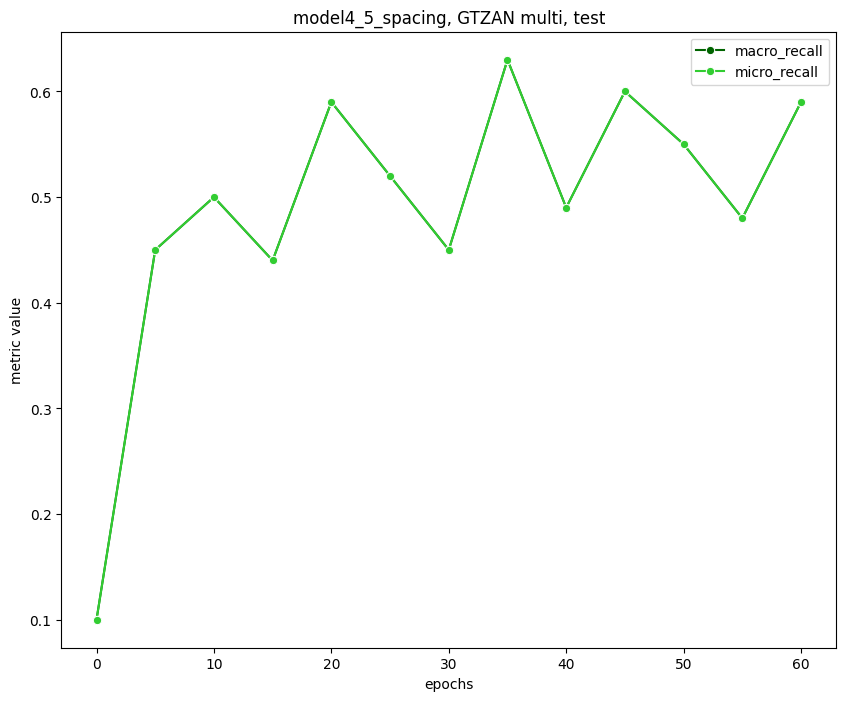

In [112]:
draw_figures_for_multi_model(base_dir=gtzan_multi_output_dir,
                             model_name='model4_5_spacing',
                             classes=gtzan_classes,
                             metrics_with_colors=single_multi_metrics)

## Model5_10_spacing

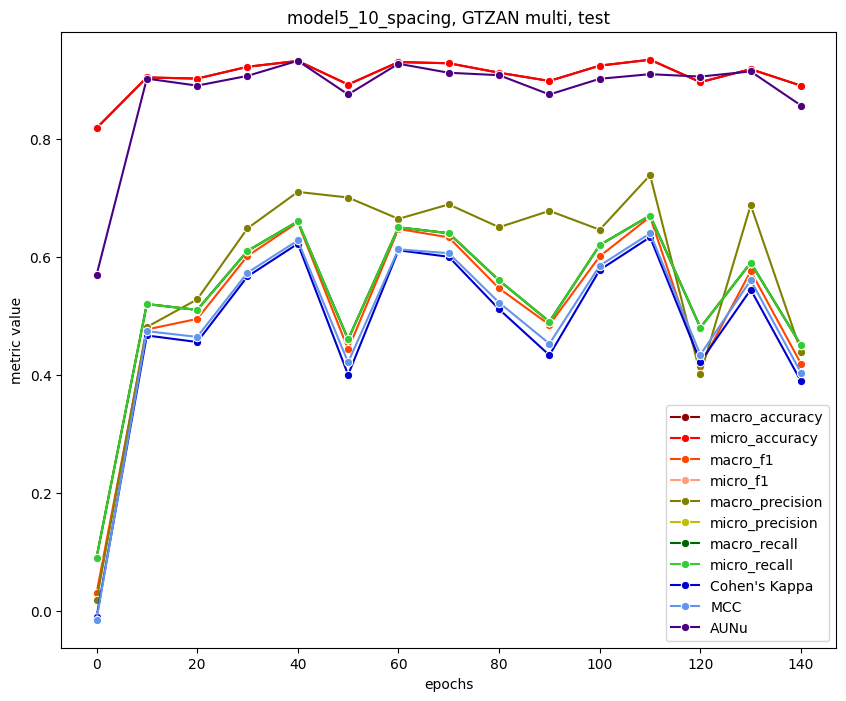

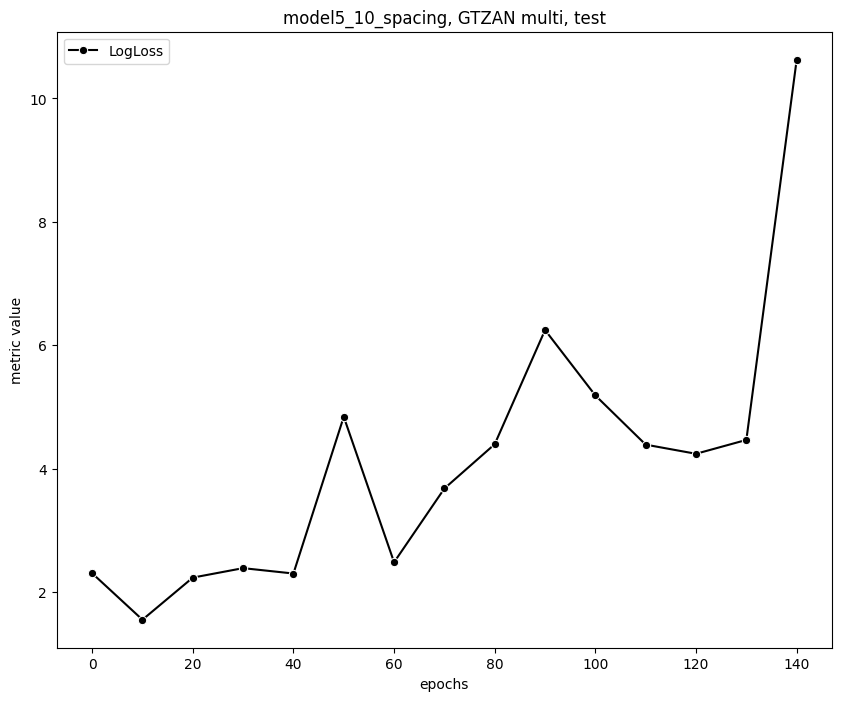

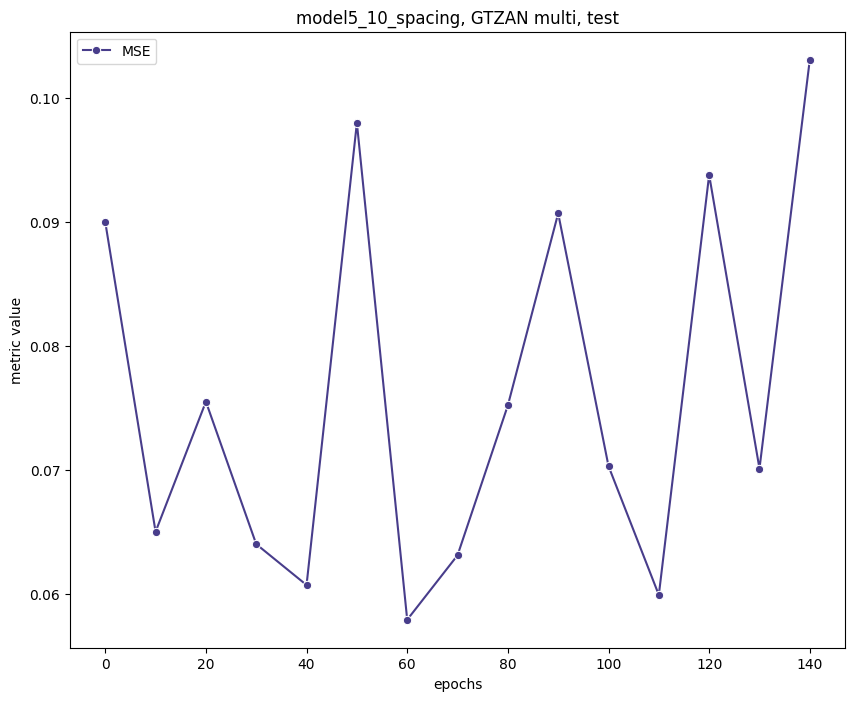

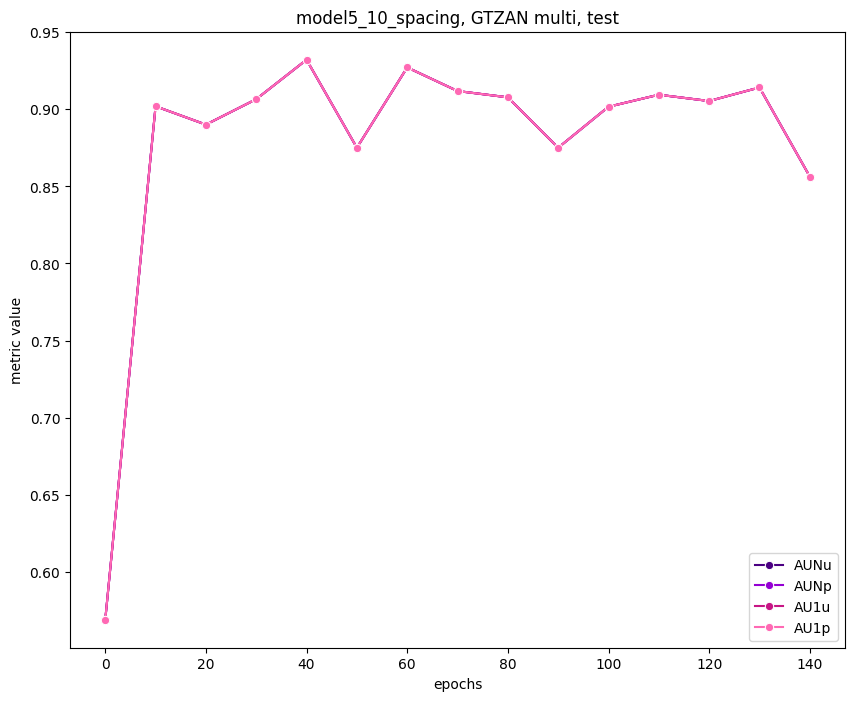

macro_accuracy is same as micro_accuracy in every epoch: True


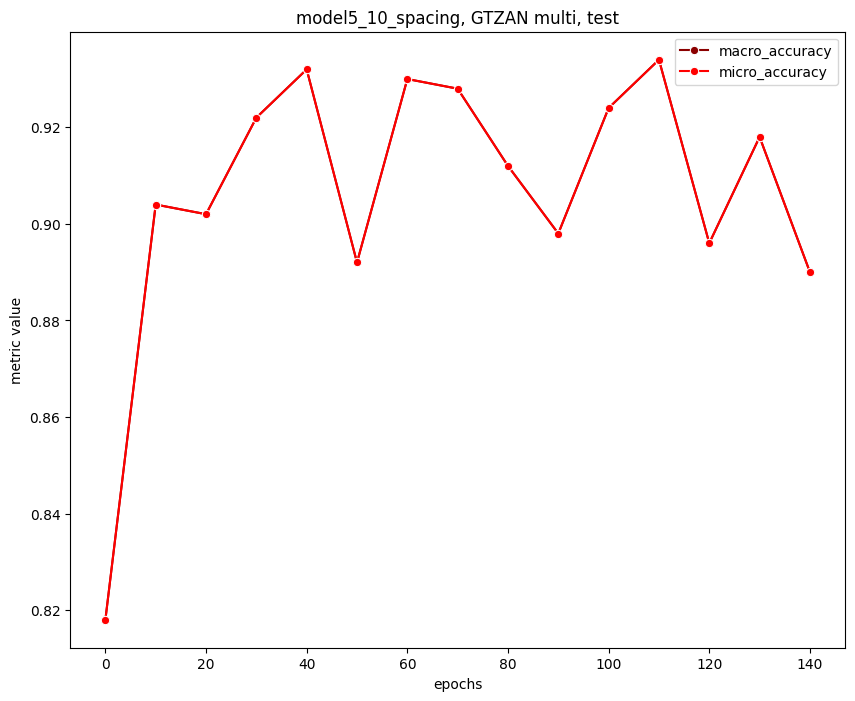

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.06439999999999996 in epoch 120


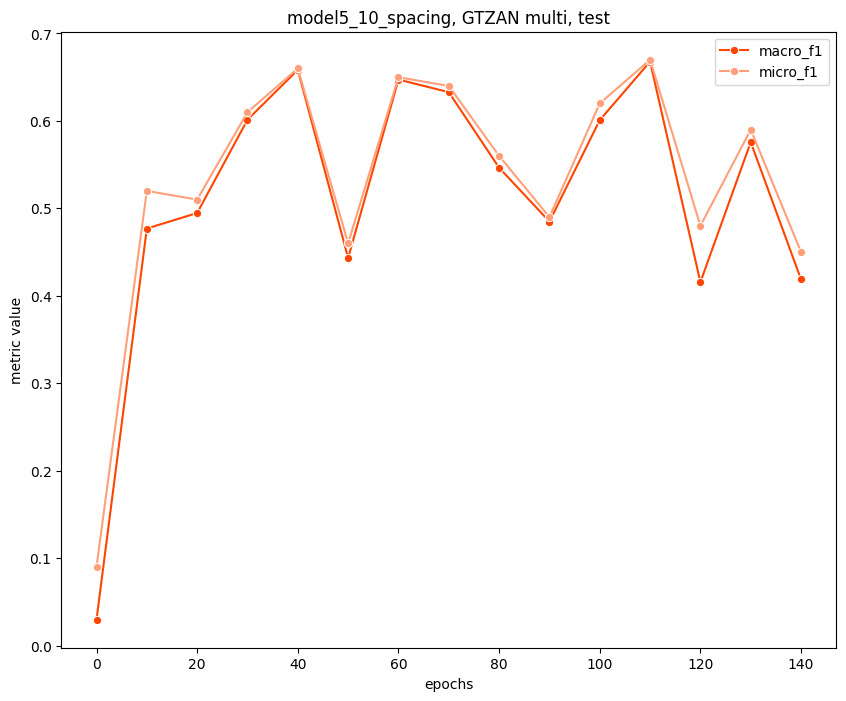

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.2405 in epoch 50


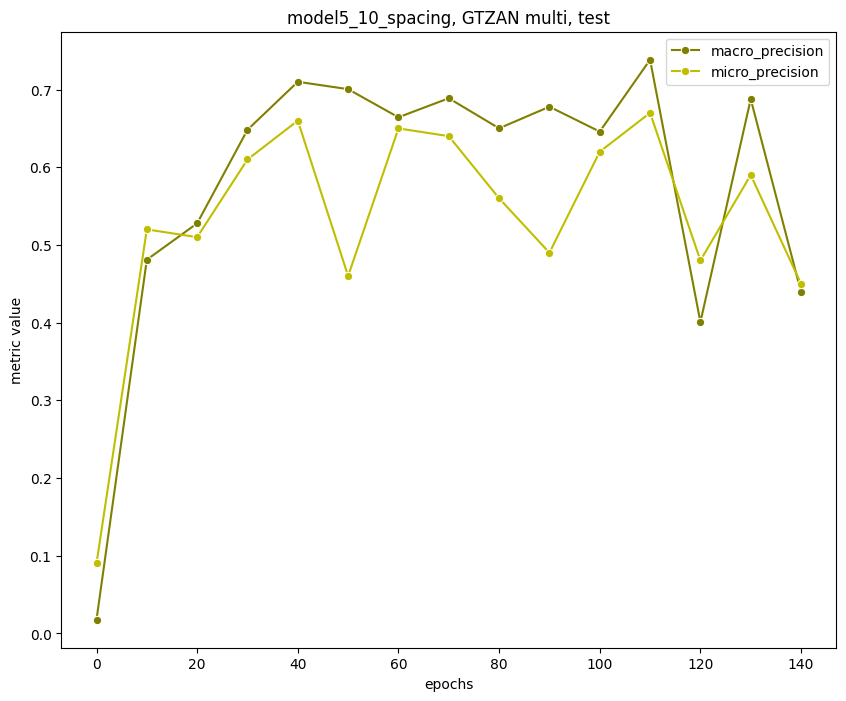

macro_recall is same as micro_recall in every epoch: True


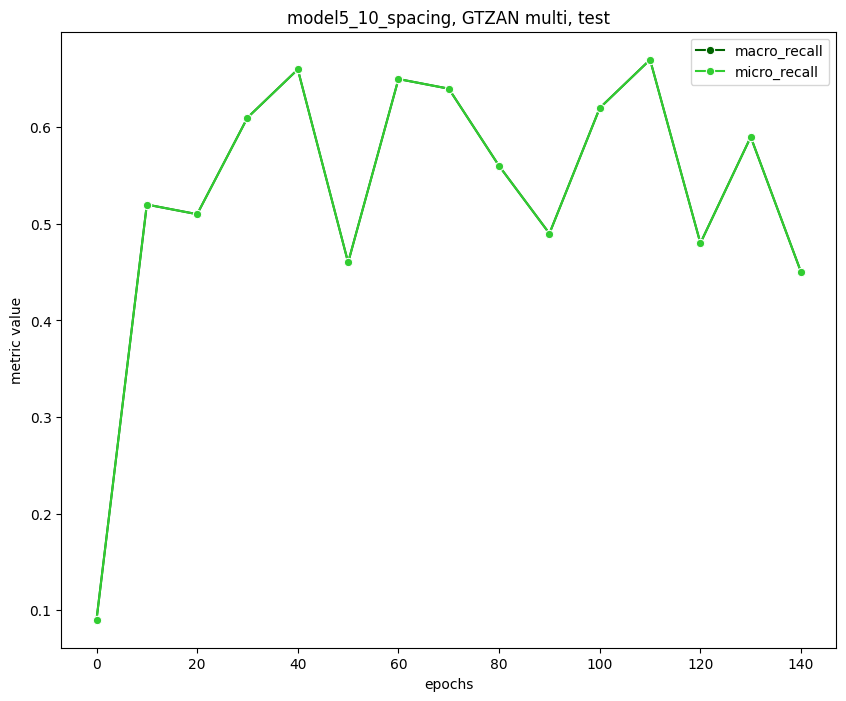

In [113]:
draw_figures_for_multi_model(base_dir=gtzan_multi_output_dir,
                             model_name='model5_10_spacing',
                             classes=gtzan_classes,
                             metrics_with_colors=single_multi_metrics)

# FMA small multi

In [114]:
fma_small_multi_output_dir = report_output_dirs['fma_small_multi']

## model1_5_spacing

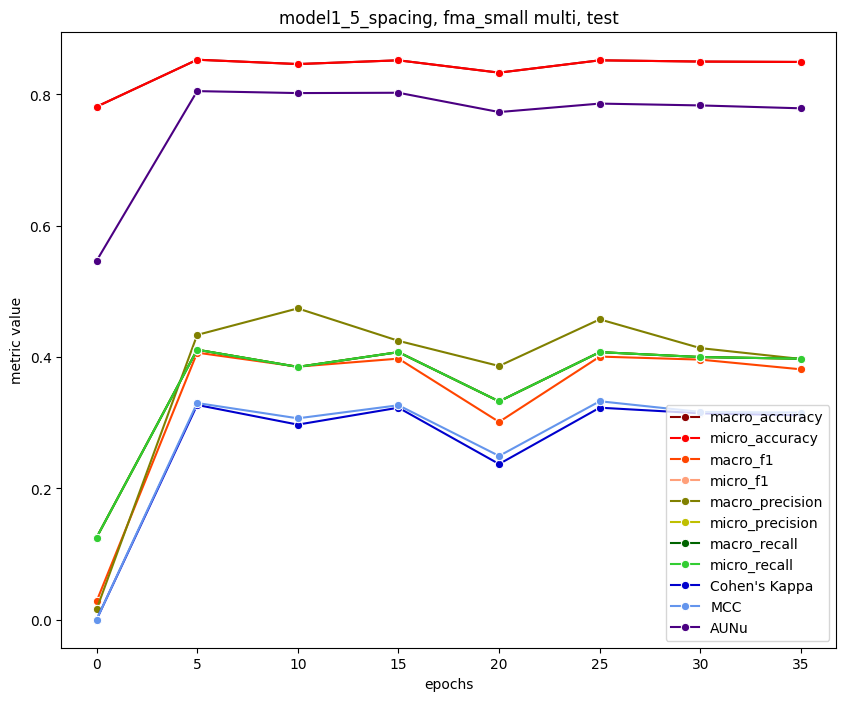

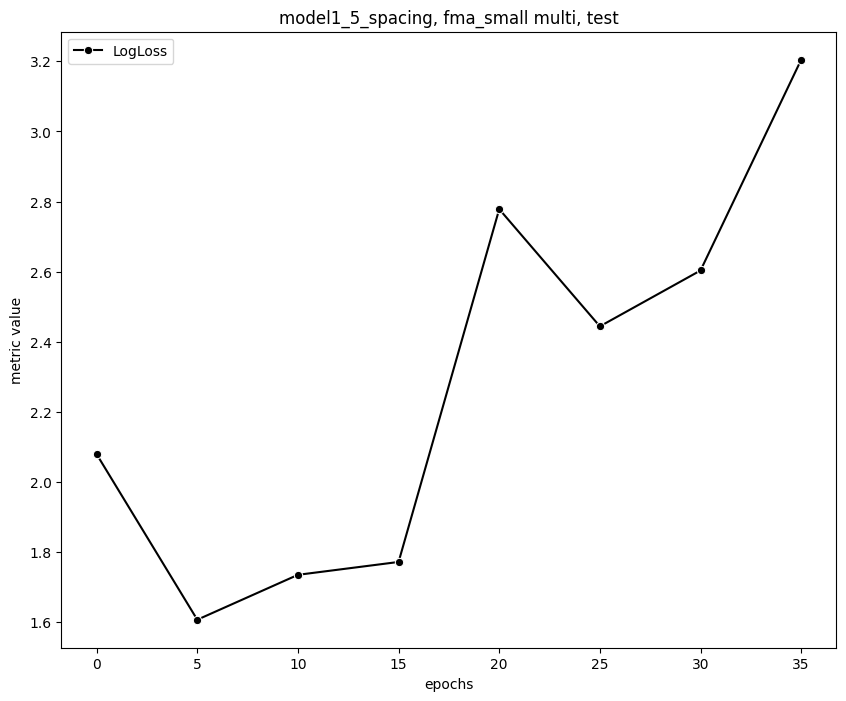

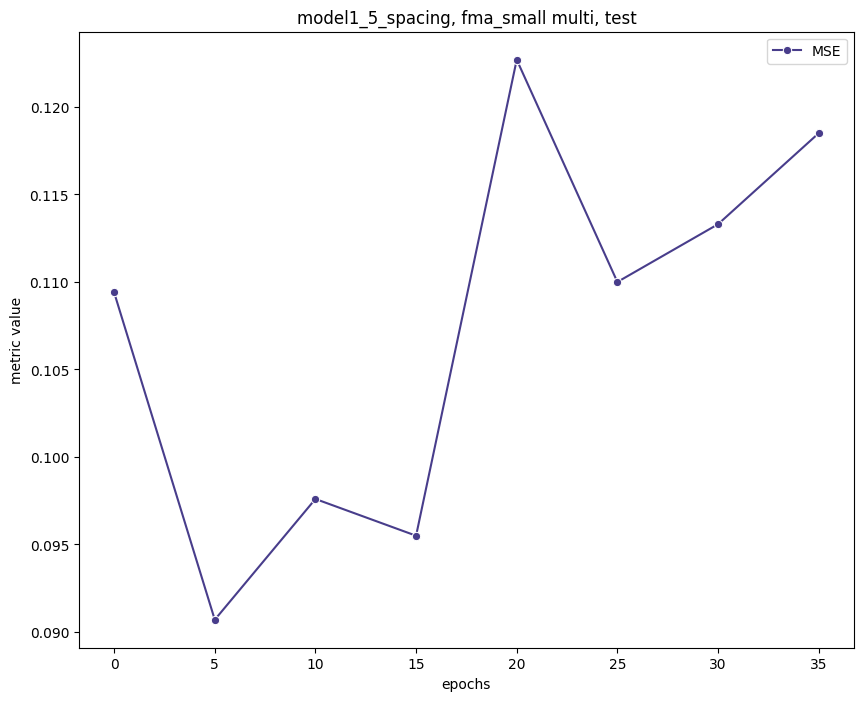

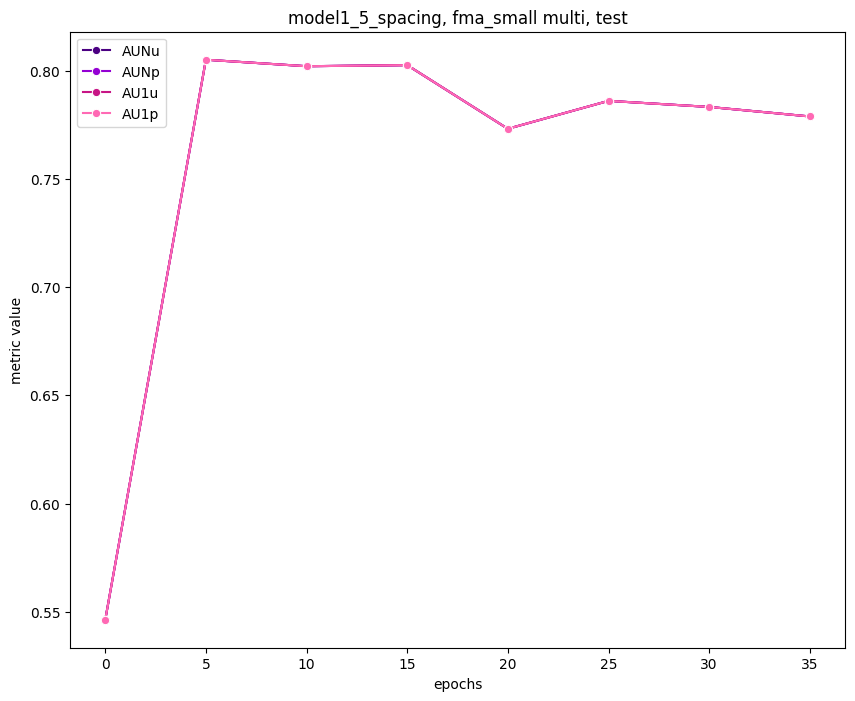

macro_accuracy is same as micro_accuracy in every epoch: True


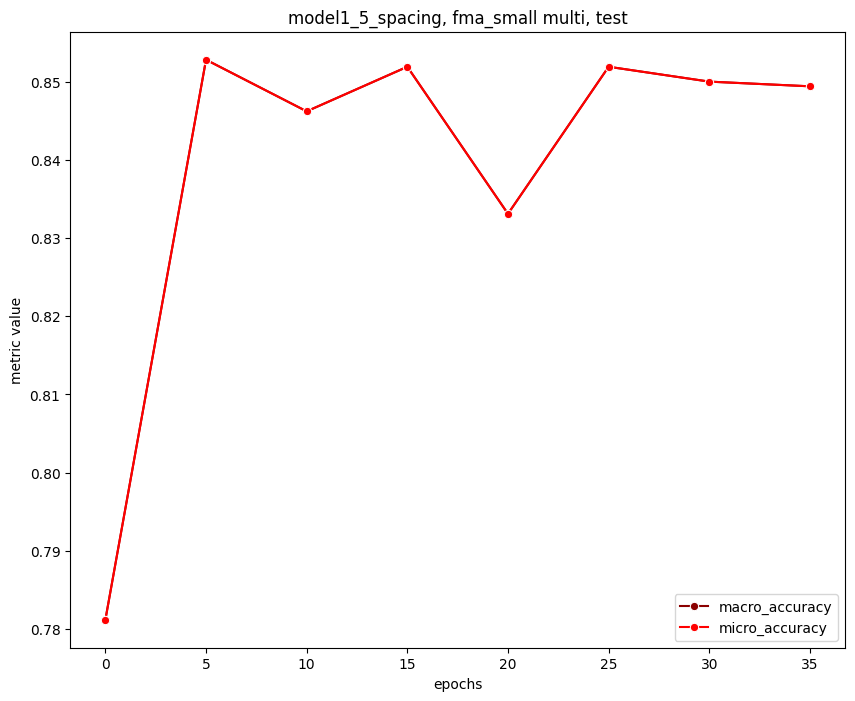

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.09720000000000001 in epoch 0


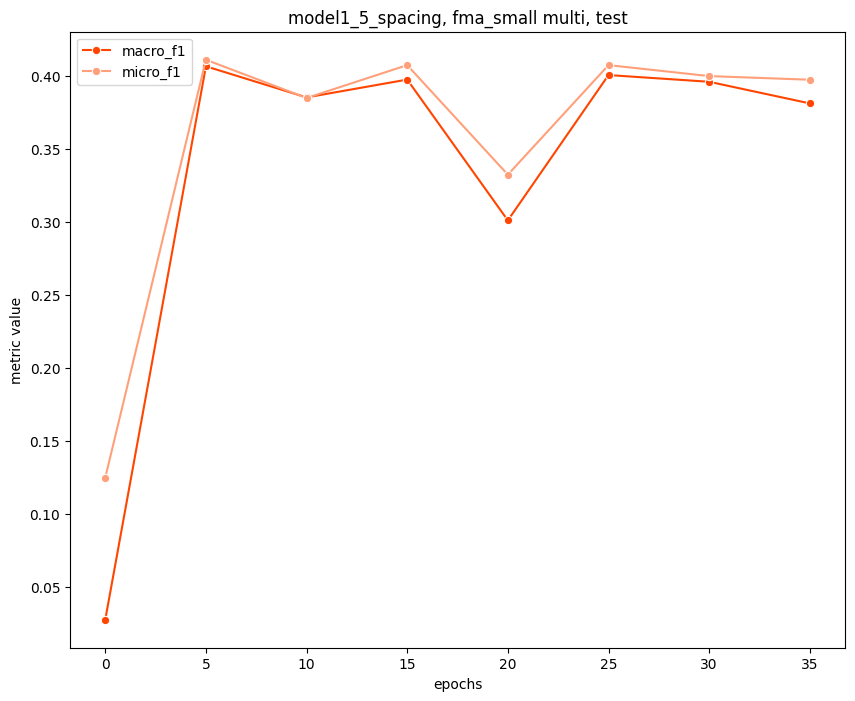

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.1094 in epoch 0


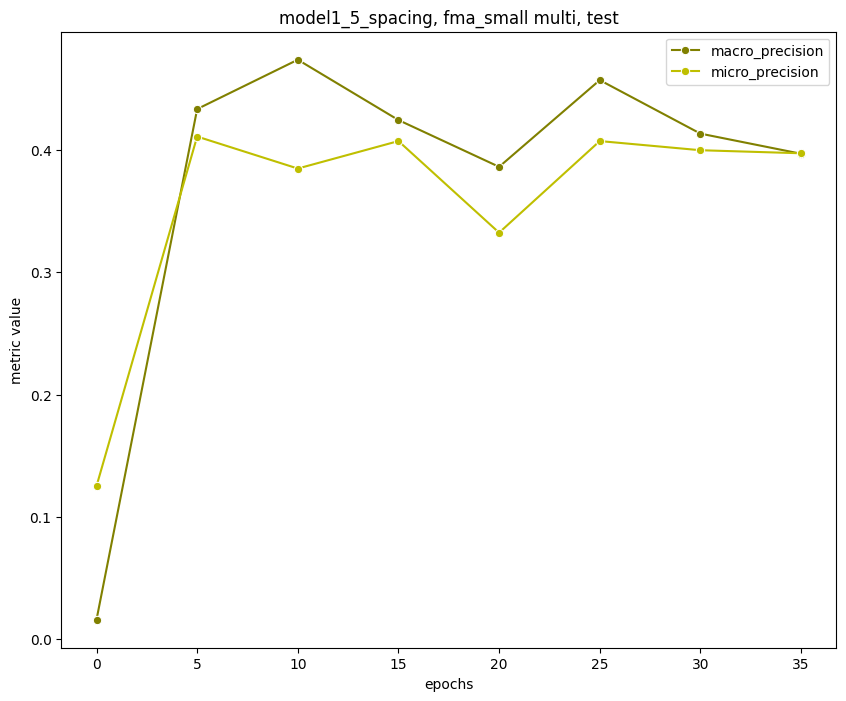

macro_recall is same as micro_recall in every epoch: True


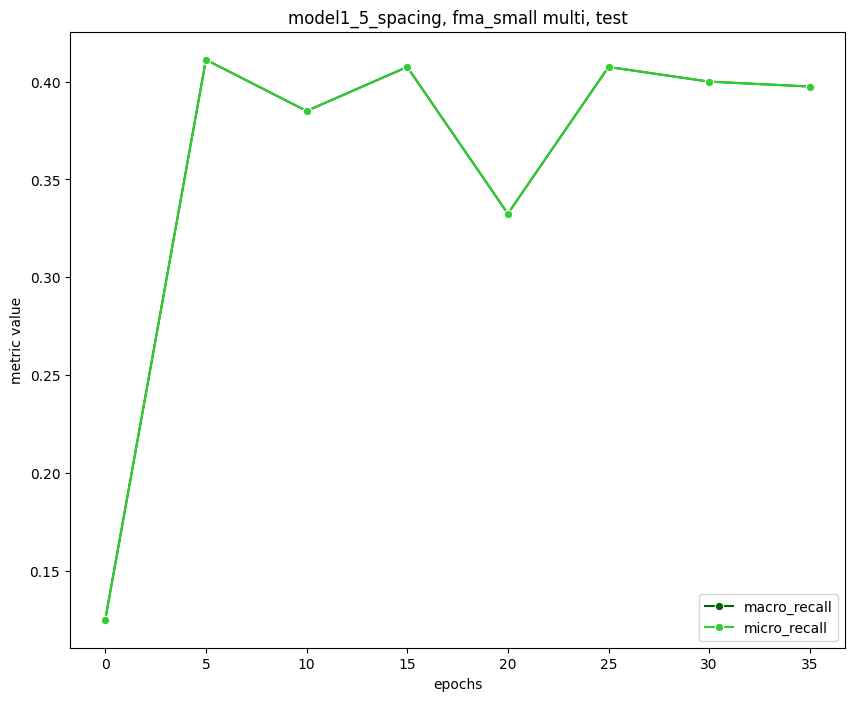

In [115]:
draw_figures_for_multi_model(base_dir=fma_small_multi_output_dir,
                             model_name='model1_5_spacing',
                             classes=fma_small_top_classes,
                             metrics_with_colors=single_multi_metrics)

## model2_10_spacing

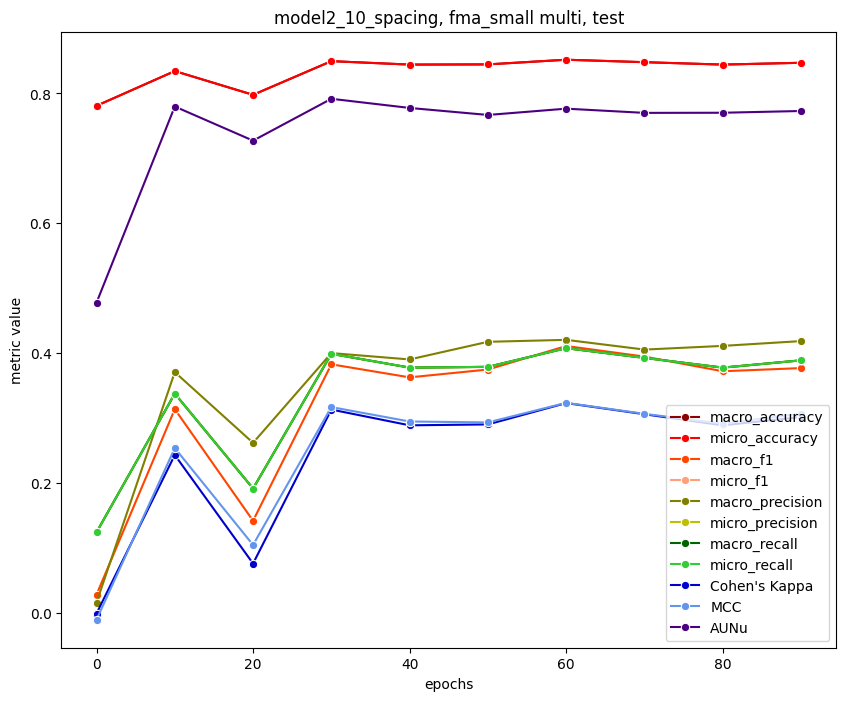

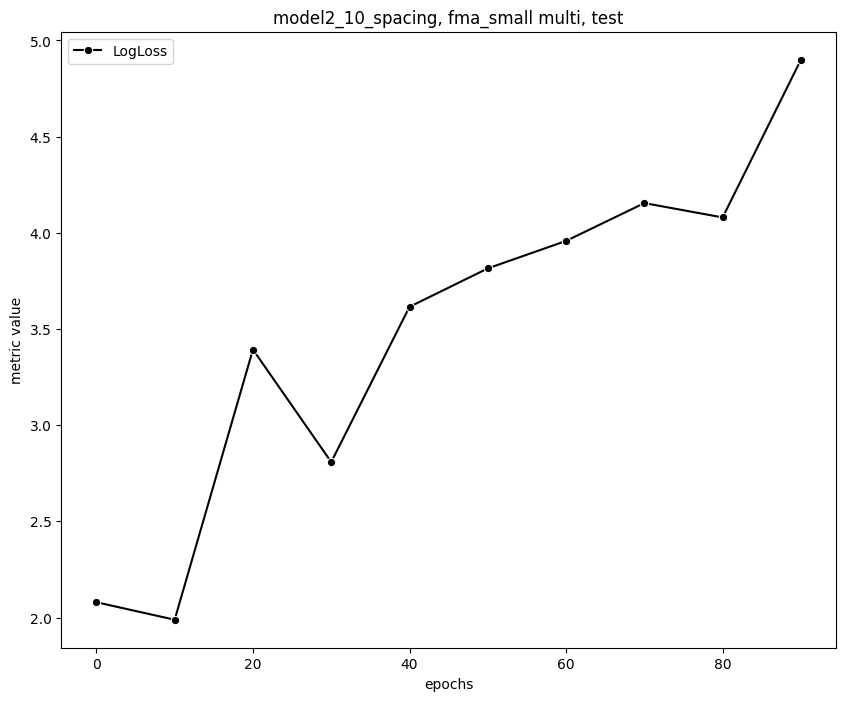

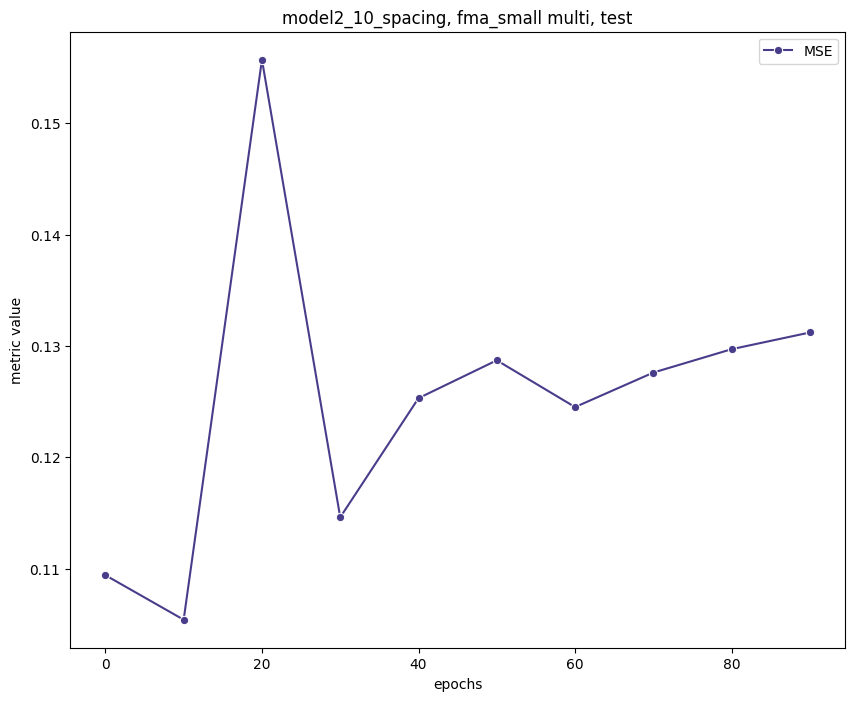

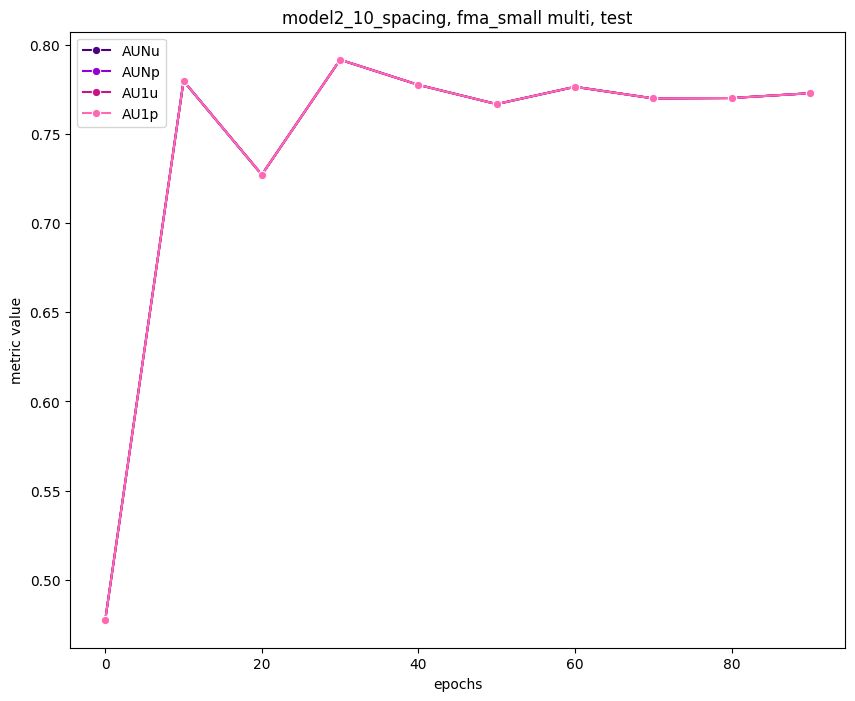

macro_accuracy is same as micro_accuracy in every epoch: True


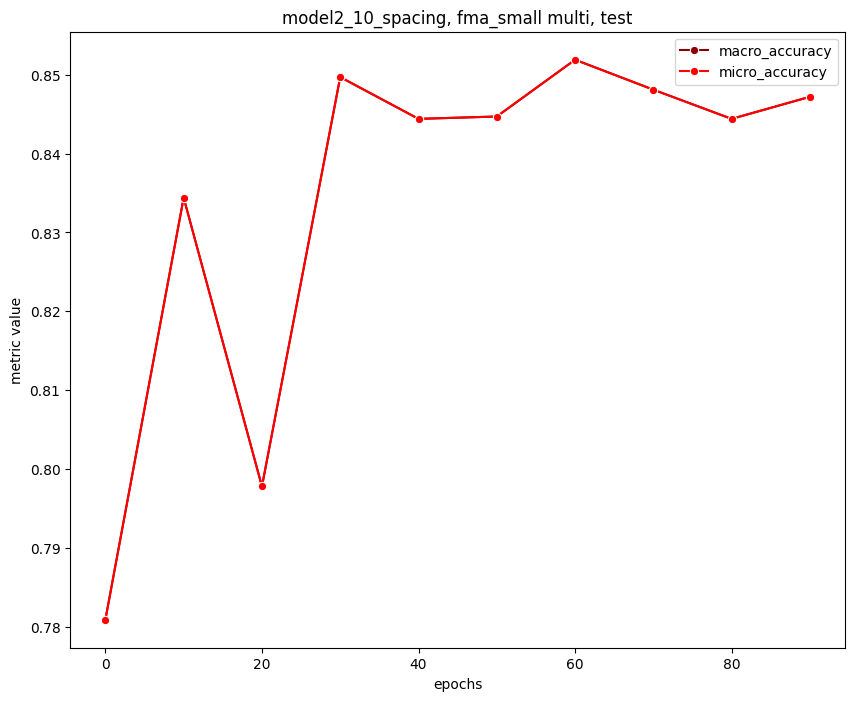

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.09609999999999999 in epoch 0


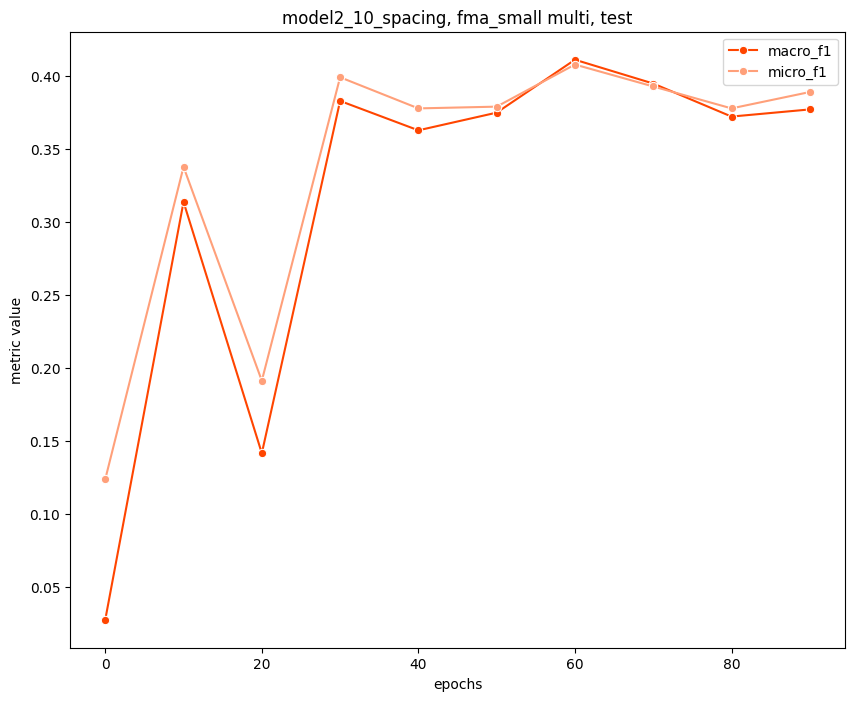

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.10819999999999999 in epoch 0


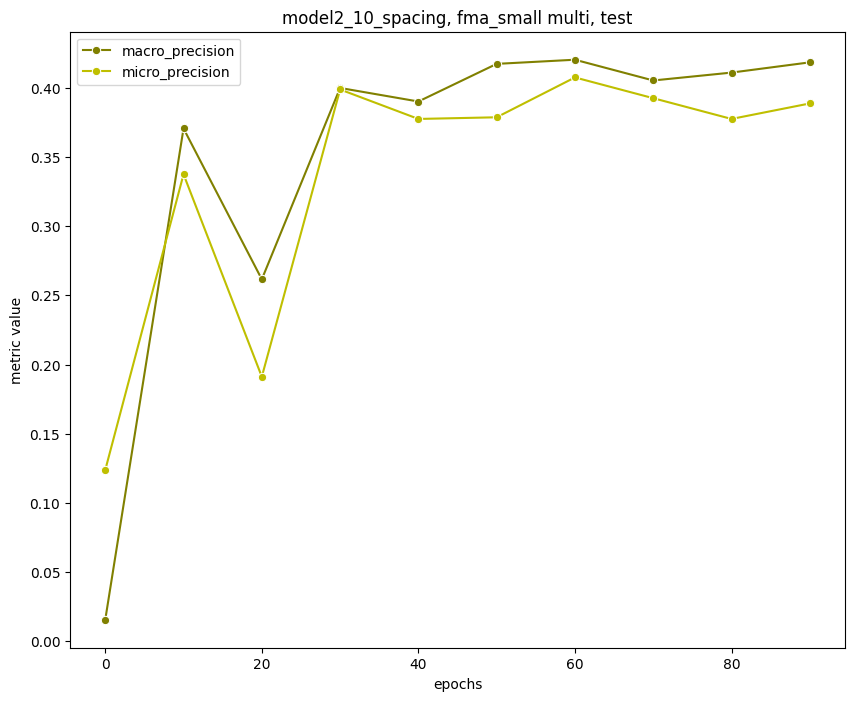

macro_recall is same as micro_recall in every epoch: False
Biggest difference: 9.999999999998899e-05 in epoch 90


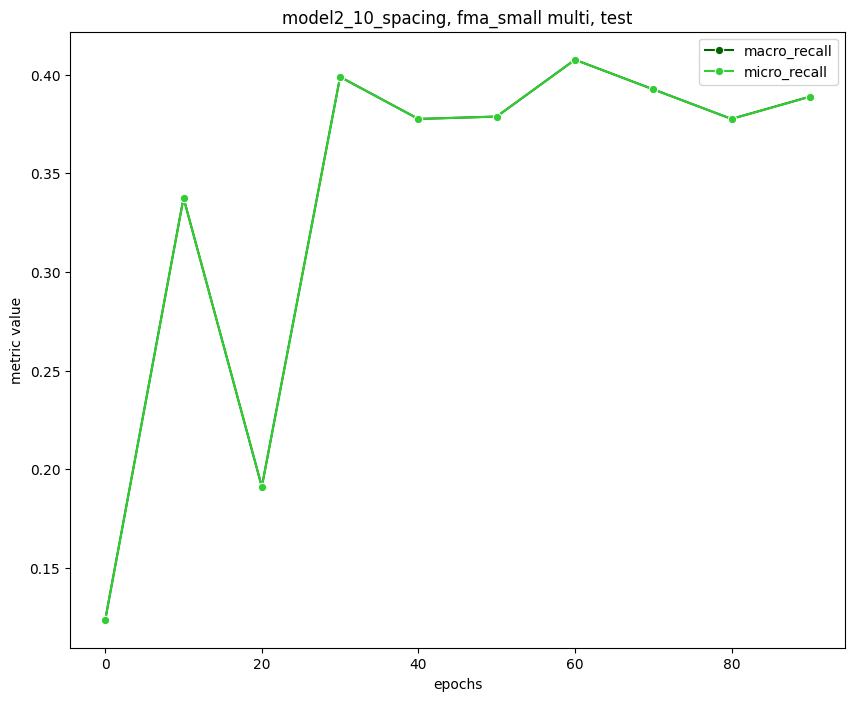

In [118]:
draw_figures_for_multi_model(base_dir=fma_small_multi_output_dir,
                             model_name='model2_10_spacing',
                             classes=fma_small_top_classes,
                             metrics_with_colors=single_multi_metrics)

## model3_10_spacing

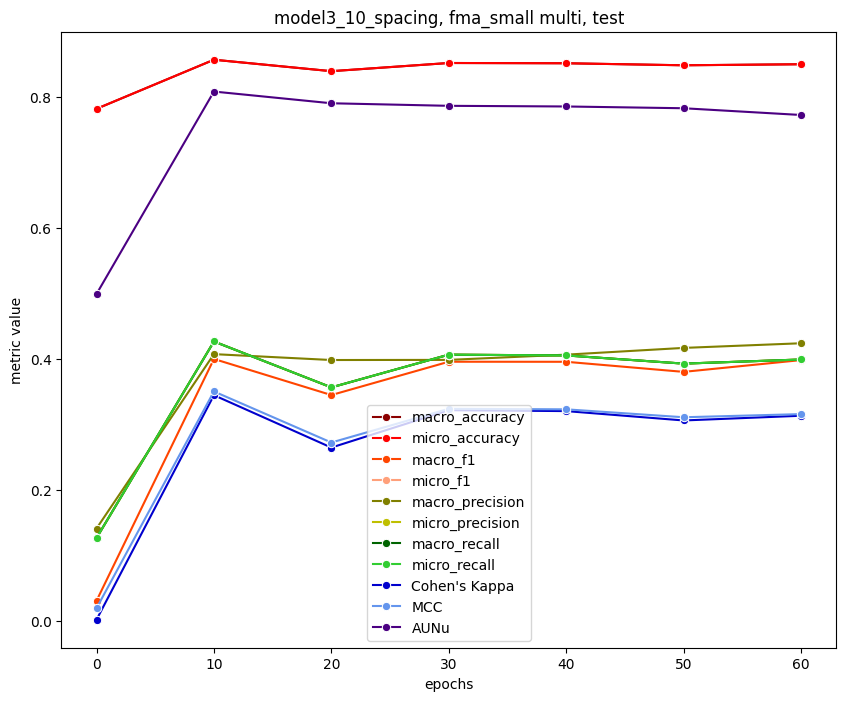

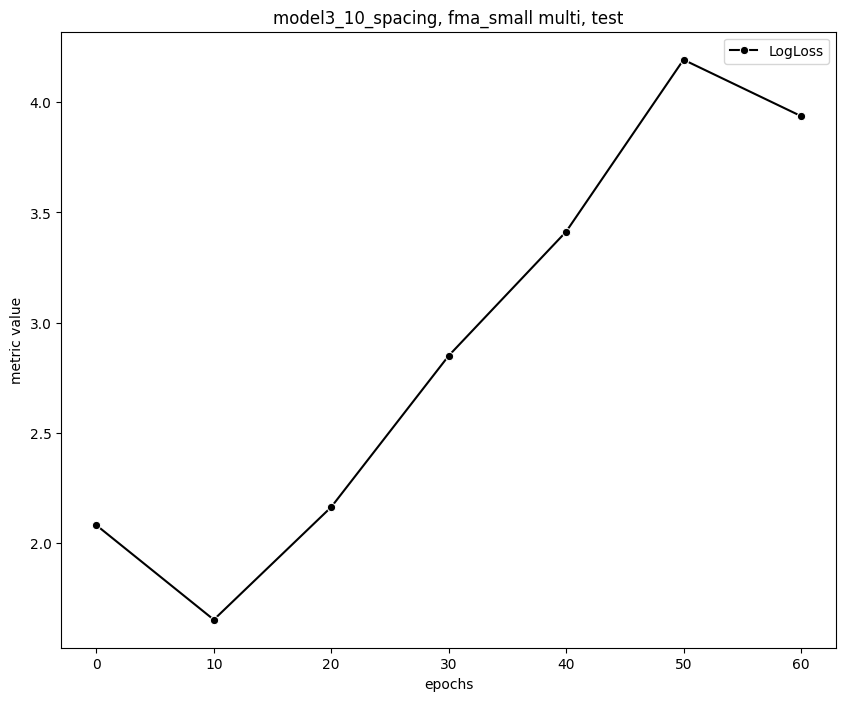

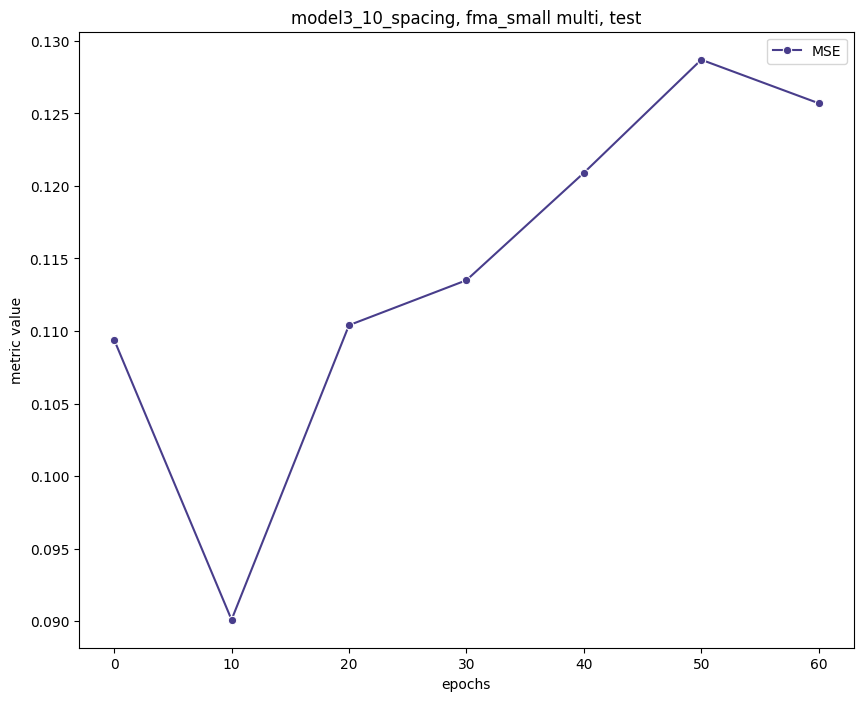

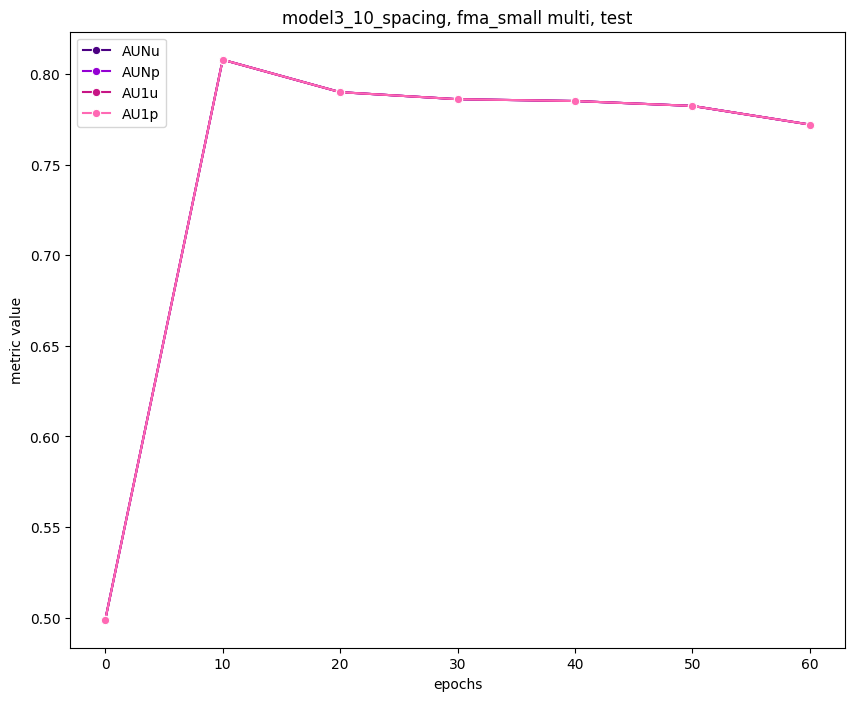

macro_accuracy is same as micro_accuracy in every epoch: True


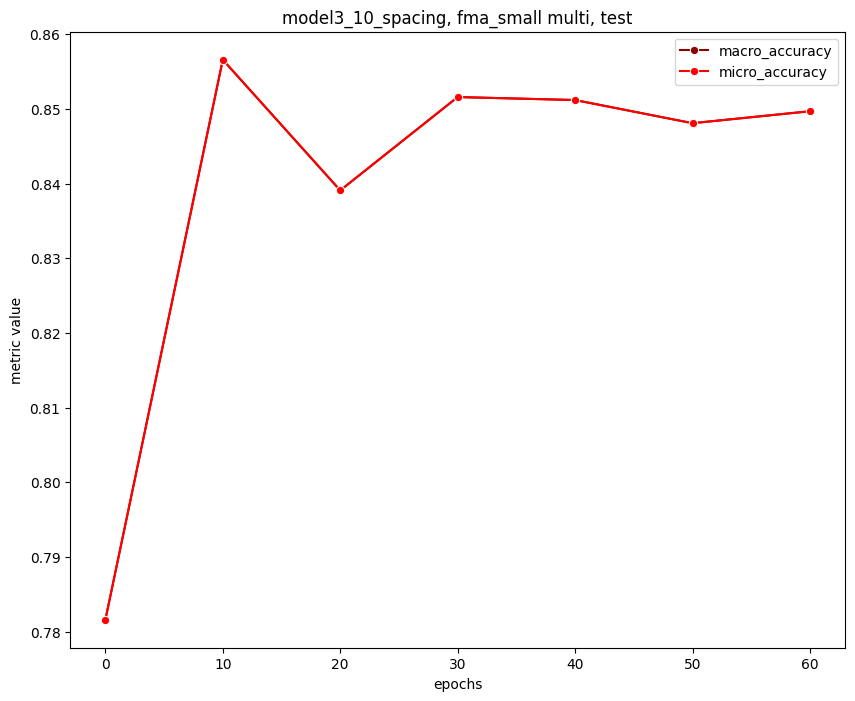

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.09590000000000001 in epoch 0


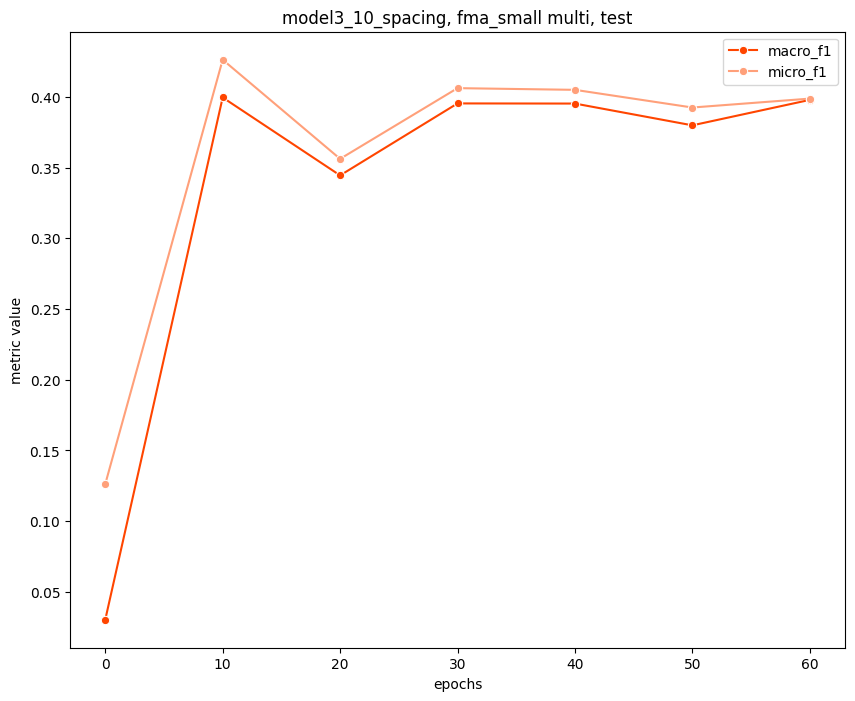

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.041800000000000004 in epoch 20


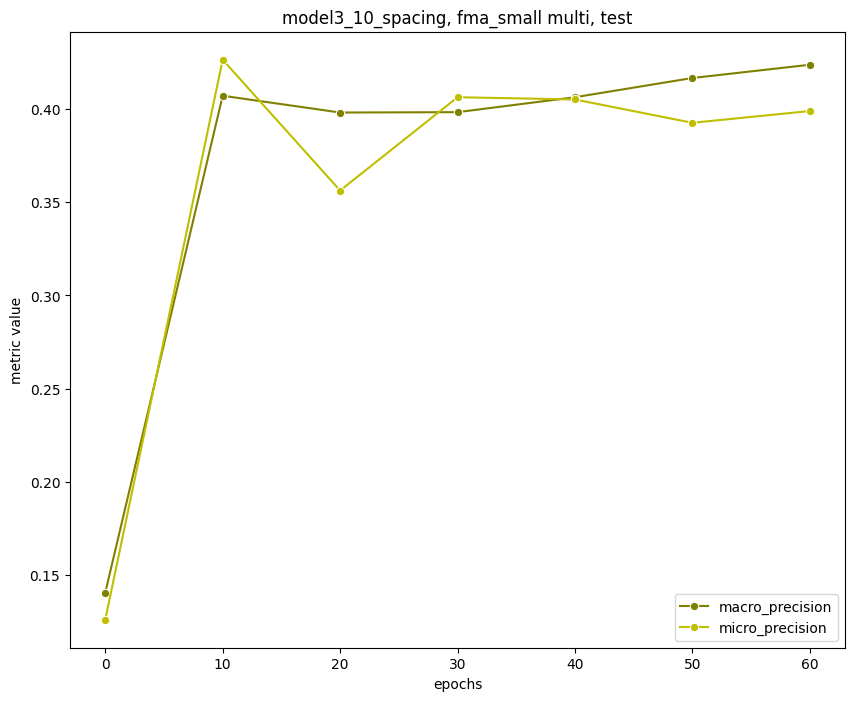

macro_recall is same as micro_recall in every epoch: True


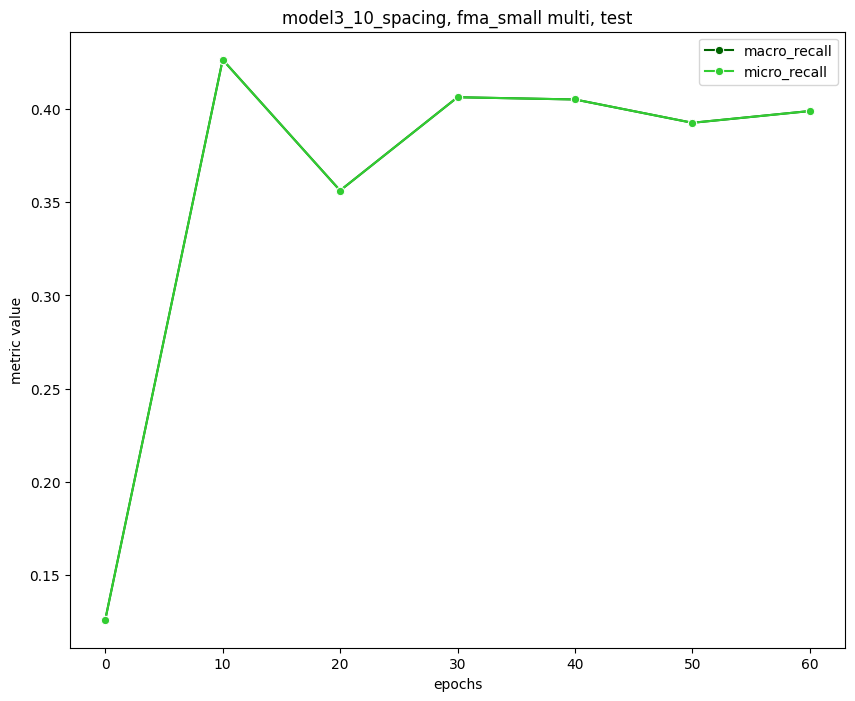

In [119]:
draw_figures_for_multi_model(base_dir=fma_small_multi_output_dir,
                             model_name='model3_10_spacing',
                             classes=fma_small_top_classes,
                             metrics_with_colors=single_multi_metrics)

# FMA medium multi

In [48]:
fma_medium_multi_output_dir = report_output_dirs['fma_medium_multi']

## model1_5_spacing

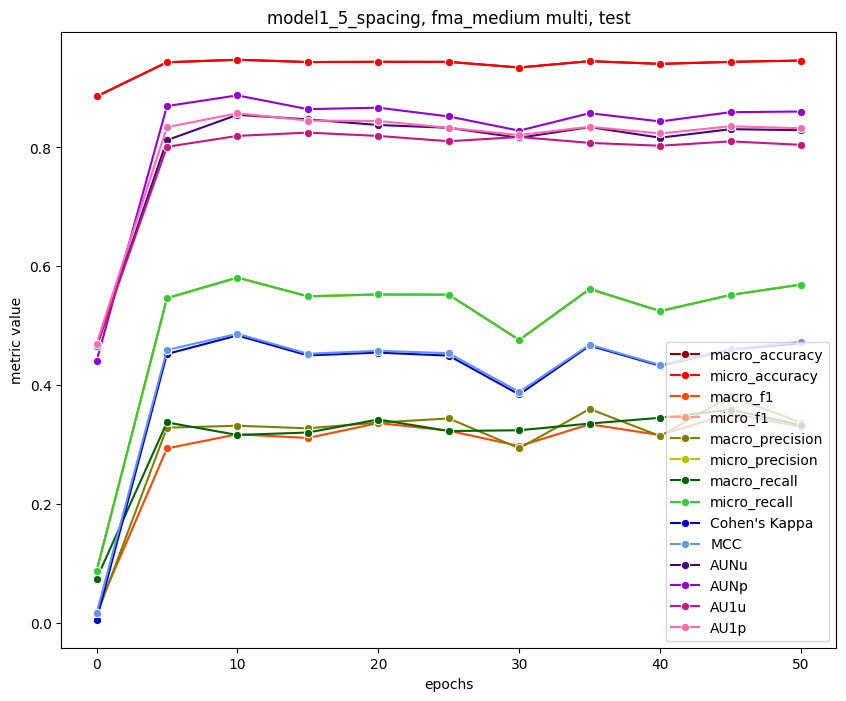

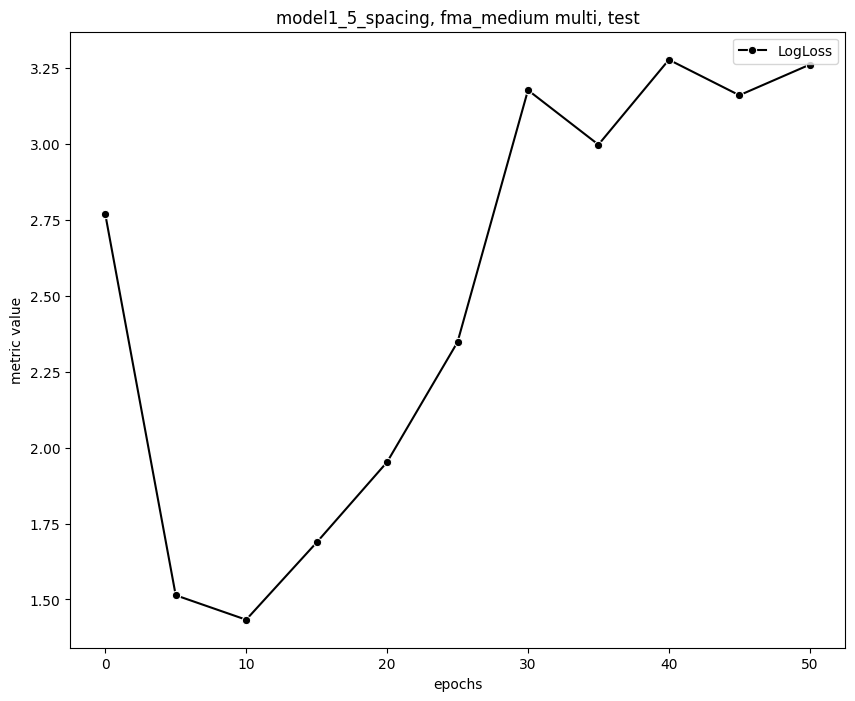

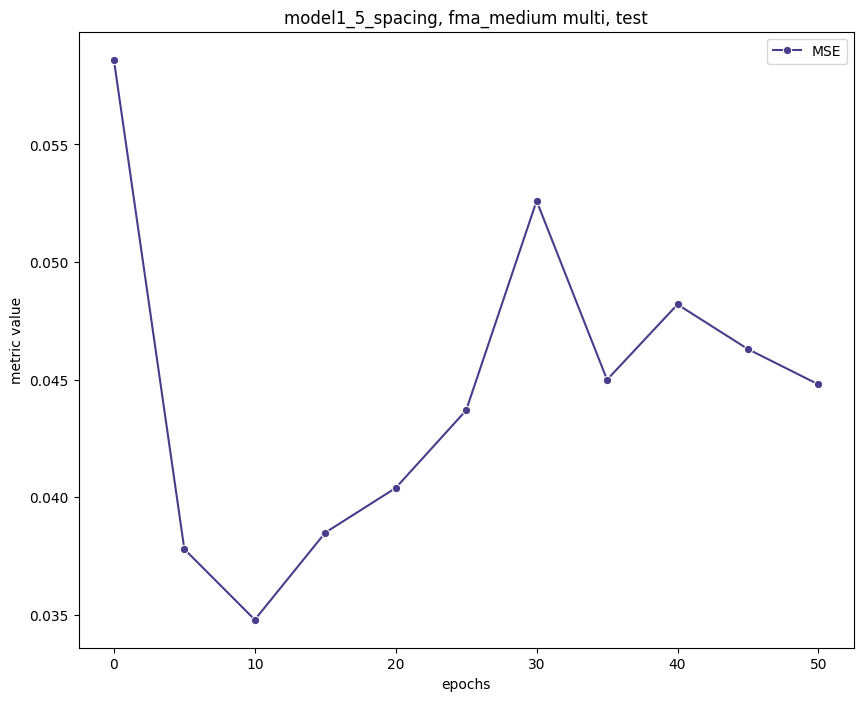

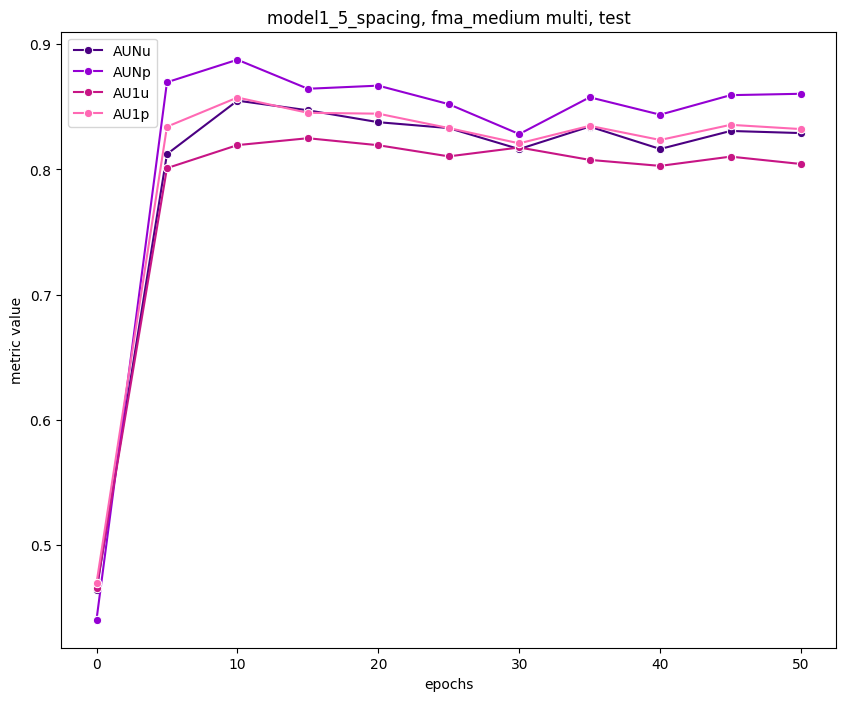

macro_accuracy is same as micro_accuracy in every epoch: True


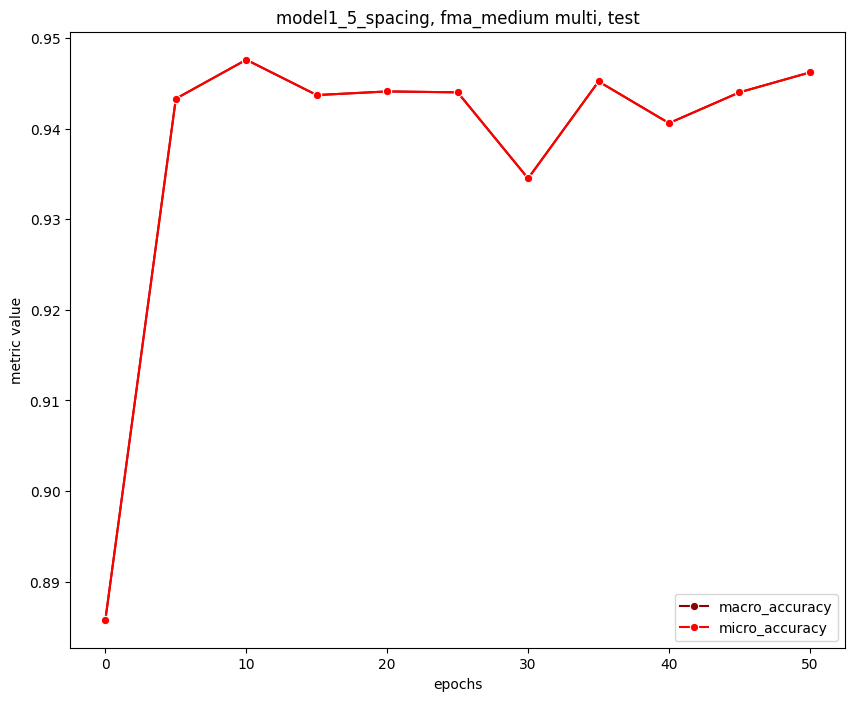

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.2637 in epoch 10


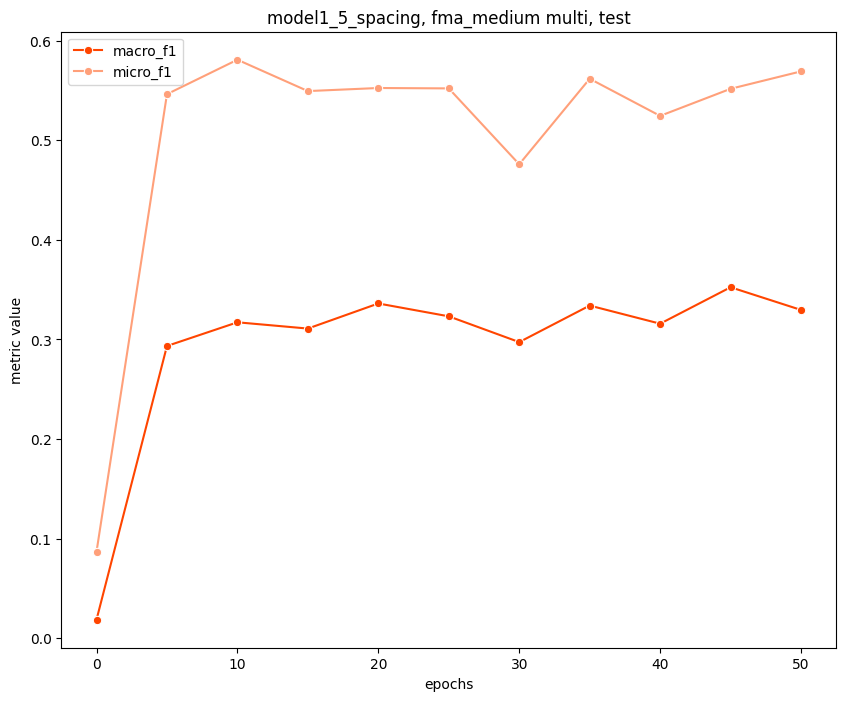

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.24939999999999996 in epoch 10


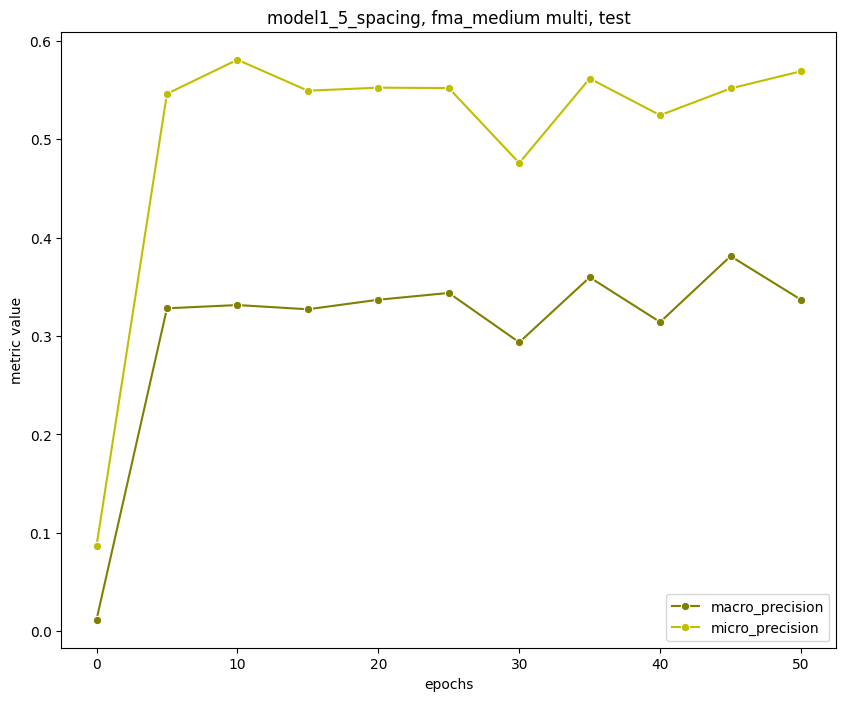

macro_recall is same as micro_recall in every epoch: False
Biggest difference: 0.26489999999999997 in epoch 10


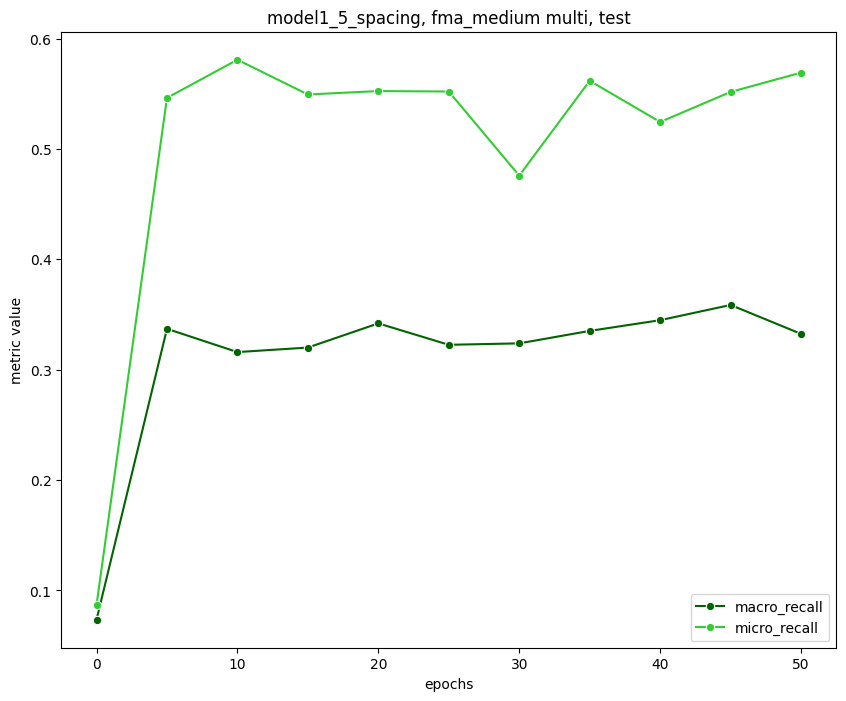

In [120]:
draw_figures_for_multi_model(base_dir=fma_medium_multi_output_dir,
                             model_name='model1_5_spacing',
                             classes=fma_medium_top_classes,
                             metrics_with_colors=single_multi_metrics,
                             same_class_counts=False)

## model2_5_spacing